# Analisis exploratorio profundo

In [3]:
import pandas as pd
import numpy as np

# Leer los archivos CSV correctamente
df_dim_jugador = pd.read_csv(r'C:\Users\PC\Documents\HENRY\MOD PROYECTO FINAL\tablas para analisis\dim_jugador.csv')
df_play_by_play_clean = pd.read_csv(r'C:\Users\PC\Documents\HENRY\MOD PROYECTO FINAL\tablas para analisis\play_by_play_clean.csv')
df_dim_team = pd.read_csv(r'C:\Users\PC\Documents\HENRY\MOD PROYECTO FINAL\tablas para analisis\dim_team.csv')
df_dim_estadio = pd.read_csv(r'C:\Users\PC\Documents\HENRY\MOD PROYECTO FINAL\tablas para analisis\dim_estadio.csv')
df_dim_tiempo = pd.read_csv(r'C:\Users\PC\Documents\HENRY\MOD PROYECTO FINAL\PROYECTO FINAL\dim_tiempo.csv')
df_fact_partidos_2010_2023 = pd.read_csv(r'C:\Users\PC\Documents\HENRY\MOD PROYECTO FINAL\PROYECTO FINAL\fact_partidos_2010_2023.csv')


# Mostrar las primeras filas
print(df_dim_jugador.head())
print(df_play_by_play_clean.head())



   player_id         full_name first_name last_name is_active  birth_date  \
0        100        Tim Legler        Tim    Legler     False  1966-12-26   
1       1000  Shandon Anderson    Shandon  Anderson     False  1973-12-31   
2       1001               NaN        NaN       NaN       NaN         NaN   
3       1002      Reggie Geary     Reggie     Geary     False  1973-08-31   
4     100263     Bill Laimbeer       Bill  Laimbeer     False  1900-01-01   

  country   college       position position_group  ...  \
0     USA  La Salle          GUARD          GUARD  ...   
1     USA   Georgia  GUARD-FORWARD  GUARD-FORWARD  ...   
2     NaN       NaN            NaN            NaN  ...   
3     USA   Arizona          GUARD          GUARD  ...   
4     USA       NaN         CENTER         CENTER  ...   

   combine_height_wo_shoes_ft_in  combine_height_w_shoes  \
0                            NaN                     NaN   
1                            NaN                     NaN   
2       

In [15]:
print(df_play_by_play_clean.columns.tolist())


['game_id', 'eventnum', 'eventmsgtype', 'eventmsgactiontype', 'period', 'wctimestring', 'pctimestring', 'score', 'scoremargin', 'player1_id', 'player1_name', 'player1_team_id', 'player2_id', 'player2_name', 'player2_team_id', 'game_date', 'season']


# Creación de dataframe jugadores

In [17]:
import pandas as pd
import numpy as np
from functools import reduce

def generar_dataset_por_jugador_temporada(play_by_play_clean: pd.DataFrame,
                                           dim_jugador: pd.DataFrame,
                                           dim_team: pd.DataFrame) -> pd.DataFrame:
    pbp = play_by_play_clean.copy()
    dj = dim_jugador.copy()
    dt = dim_team.copy()

    # Validar que 'season' exista
    if 'season' not in pbp.columns:
        raise ValueError("La columna 'season' no existe en play_by_play")

    # 1. PUNTOS
    puntos_campo = pbp[pbp['eventmsgtype'] == 1].groupby(['player1_id', 'season']).size() * 2
    puntos_libres = pbp[pbp['eventmsgtype'] == 3].groupby(['player1_id', 'season']).size()
    df_puntos = puntos_campo.add(puntos_libres, fill_value=0).reset_index()
    df_puntos.columns = ['player_id', 'season', 'puntos']

    # 2. ASISTENCIAS
    df_asist = (
        pbp[(pbp['eventmsgtype'] == 1) & pbp['player2_id'].notna()]
        .groupby(['player2_id', 'season'])
        .size()
        .reset_index(name='asistencias')
        .rename(columns={'player2_id': 'player_id'})
    )

    # 3. FALTAS
    df_faltas = (
        pbp[pbp['eventmsgtype'] == 6]
        .groupby(['player1_id', 'season'])
        .size()
        .reset_index(name='faltas')
        .rename(columns={'player1_id': 'player_id'})
    )

    # 4. PÉRDIDAS
    df_perdidas = (
        pbp[pbp['eventmsgtype'] == 5]
        .groupby(['player1_id', 'season'])
        .size()
        .reset_index(name='perdidas')
        .rename(columns={'player1_id': 'player_id'})
    )

    # 5. REBOTES
    df_rebotes = (
        pbp[pbp['eventmsgtype'] == 4]
        .groupby(['player1_id', 'season'])
        .size()
        .reset_index(name='rebotes')
        .rename(columns={'player1_id': 'player_id'})
    )

    # 6. PARTIDOS JUGADOS
    df_partidos = (
        pbp[['game_id', 'player1_id', 'season']]
        .dropna()
        .drop_duplicates(subset=['game_id', 'player1_id', 'season'])
        .groupby(['player1_id', 'season'])
        .size()
        .reset_index(name='partidos_jugados')
        .rename(columns={'player1_id': 'player_id'})
    )

    # 7. EQUIPO PRINCIPAL POR TEMPORADA (reemplazo team_id por player1_team_id)
    df_team_count = (
        pbp[['player1_id', 'player1_team_id', 'season']]
        .dropna()
        .groupby(['player1_id', 'season', 'player1_team_id'])
        .size()
        .reset_index(name='count')
    )
    df_team_main = (
        df_team_count.sort_values(['player1_id', 'season', 'count'], ascending=[True, True, False])
        .drop_duplicates(subset=['player1_id', 'season'])
        .rename(columns={'player1_id': 'player_id', 'player1_team_id': 'team_id_main'})
    )

    # 8. UNIÓN DE TODAS LAS MÉTRICAS
    dfs = [df_puntos, df_asist, df_faltas, df_perdidas, df_rebotes, df_partidos]
    df_all = reduce(lambda left, right: pd.merge(left, right, on=['player_id', 'season'], how='outer'), dfs)

    # Rellenar NaN con 0
    metricas = ['puntos', 'asistencias', 'faltas', 'perdidas', 'rebotes', 'partidos_jugados']
    for m in metricas:
        if m in df_all.columns:
            df_all[m] = df_all[m].fillna(0).astype(int)

    # 9. AGREGAR EQUIPO PRINCIPAL
    df_all = df_all.merge(df_team_main, on=['player_id', 'season'], how='left')

    # 10. AGREGAR INFO DEL JUGADOR Y DEL EQUIPO
    df_all = df_all.merge(dj[['player_id', 'full_name', 'position', 'country']], on='player_id', how='left')
    df_all = df_all.merge(dt[['team_id', 'team_name']], left_on='team_id_main', right_on='team_id', how='left')

    # 11. MÉTRICAS POR PARTIDO
    df_all['pts_por_partido'] = np.where(df_all['partidos_jugados'] > 0,
                                         df_all['puntos'] / df_all['partidos_jugados'], 0).round(2)
    df_all['asist_por_partido'] = np.where(df_all['partidos_jugados'] > 0,
                                           df_all['asistencias'] / df_all['partidos_jugados'], 0).round(2)
    df_all['reb_por_partido'] = np.where(df_all['partidos_jugados'] > 0,
                                         df_all['rebotes'] / df_all['partidos_jugados'], 0).round(2)

    # 12. ORGANIZAR COLUMNAS
    columnas_finales = [
        'player_id', 'full_name', 'position', 'country', 'season',
        'team_id_main', 'team_name',
        'partidos_jugados',
        'puntos', 'pts_por_partido',
        'asistencias', 'asist_por_partido',
        'rebotes', 'reb_por_partido',
        'faltas', 'perdidas'
    ]
    columnas_finales = [col for col in columnas_finales if col in df_all.columns]
    df_resultado = df_all[columnas_finales]

    return df_resultado



In [19]:
df_jugadores_temporada = generar_dataset_por_jugador_temporada(
    df_play_by_play_clean,
    df_dim_jugador,
    df_dim_team
)

df_jugadores_temporada.to_csv(r'C:\Users\PC\Documents\HENRY\MOD PROYECTO FINAL\PROYECTO FINAL\jugadores_por_temporada.csv', index=False)
print("Archivo guardado correctamente.")


Archivo guardado correctamente.


In [23]:
print(df_jugadores_temporada.columns.tolist())

filas, columnas = df_jugadores_temporada.shape
print(f"Filas: {filas}")
print(f"Columnas: {columnas}")


['player_id', 'full_name', 'position', 'country', 'season', 'team_id_main', 'team_name', 'partidos_jugados', 'puntos', 'pts_por_partido', 'asistencias', 'asist_por_partido', 'rebotes', 'reb_por_partido', 'faltas', 'perdidas']
Filas: 15742
Columnas: 16


In [24]:
print(df_jugadores_temporada.head())

   player_id full_name position country  season  team_id_main team_name  \
0          0       NaN      NaN     NaN  2009.0           NaN       NaN   
1          0       NaN      NaN     NaN  2010.0           NaN       NaN   
2          0       NaN      NaN     NaN  2011.0           NaN       NaN   
3          0       NaN      NaN     NaN  2012.0           NaN       NaN   
4          0       NaN      NaN     NaN  2013.0           NaN       NaN   

   partidos_jugados  puntos  pts_por_partido  asistencias  asist_por_partido  \
0               678       0              0.0        22539              33.24   
1              1093       0              0.0        34679              31.73   
2               845       0              0.0        26268              31.09   
3                72       0              0.0         2584              35.89   
4              1182       0              0.0        36820              31.15   

   rebotes  reb_por_partido  faltas  perdidas  
0        0          

In [26]:
# Filtrar la temporada entre 2010 y 2023 inclusive
df_jugadores_temporada = df_jugadores_temporada[
    (df_jugadores_temporada['season'] >= 2010) & (df_jugadores_temporada['season'] <= 2023)
]

# Eliminar columnas que tienen solo valores NaN
df_jugadores_temporada = df_jugadores_temporada.dropna(axis=1, how='all')

# Eliminar filas que tienen cualquier valor NaN
df_jugadores_temporada = df_jugadores_temporada.dropna(axis=0, how='any')

# Guardar el DataFrame limpio y filtrado a CSV
df_jugadores_temporada.to_csv(r'C:\Users\PC\Documents\HENRY\MOD PROYECTO FINAL\PROYECTO FINAL\jugadores_por_temporada_filtrado.csv', index=False)

print("Archivo guardado correctamente con filtro de temporada 2010-2023 y sin NaNs.")


Archivo guardado correctamente con filtro de temporada 2010-2023 y sin NaNs.


# Analisis exploratorio profundo

### Eficiencia ofensiva y defensiva


C:\Users\PC\AppData\Local\Temp\ipykernel_15648\1168067597.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='team_id_home', y='poss_home', data=posesiones_prom, palette='Blues_d')


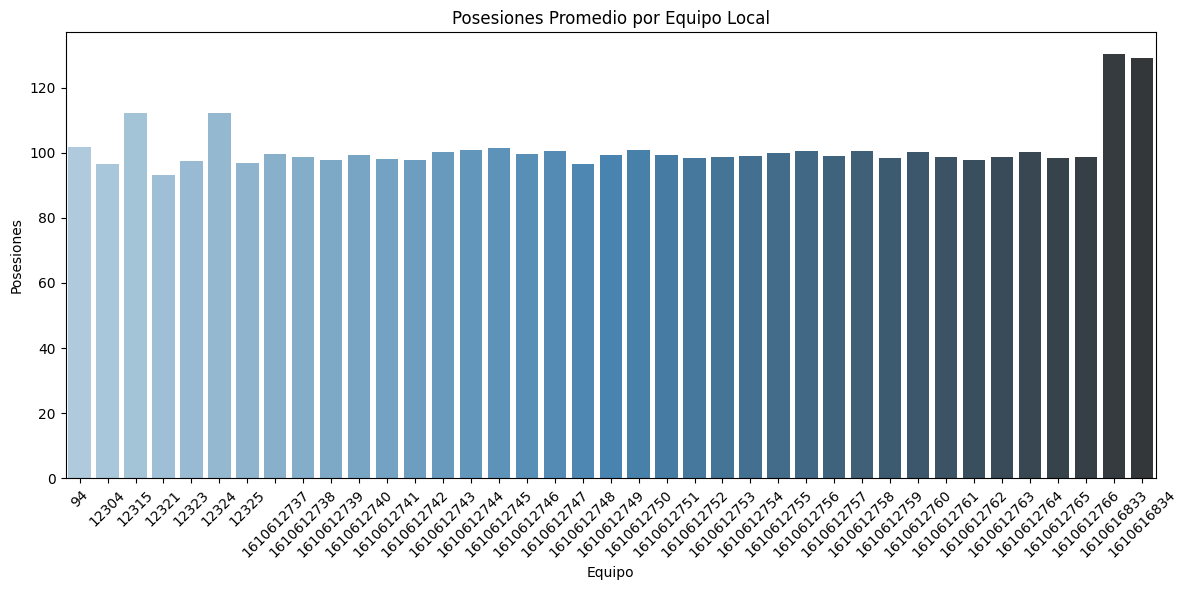

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calcular Posesiones
df_fact_partidos_2010_2023['poss_home'] = (
    df_fact_partidos_2010_2023['fga_home'] +
    0.44 * df_fact_partidos_2010_2023['fta_home'] -
    df_fact_partidos_2010_2023['oreb_home'] +
    df_fact_partidos_2010_2023['tov_home']
)

df_fact_partidos_2010_2023['poss_away'] = (
    df_fact_partidos_2010_2023['fga_away'] +
    0.44 * df_fact_partidos_2010_2023['fta_away'] -
    df_fact_partidos_2010_2023['oreb_away'] +
    df_fact_partidos_2010_2023['tov_away']
)

# 2. Visualizar: Promedio de posesiones por equipo local
posesiones_prom = df_fact_partidos_2010_2023.groupby('team_id_home')['poss_home'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='team_id_home', y='poss_home', data=posesiones_prom, palette='Blues_d')
plt.title('Posesiones Promedio por Equipo Local')
plt.ylabel('Posesiones')
plt.xlabel('Equipo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El análisis revela que la gran mayoría de los equipos locales tienen un número promedio de posesiones muy consistente, rondando las 100 posesiones. No obstante, existe una variación notable con un pequeño grupo de equipos (especialmente los dos últimos) que logran significativamente más posesiones cuando juegan en casa, lo que podría indicar un estilo de juego más ofensivo o dominante por su parte en condición de local.

C:\Users\PC\AppData\Local\Temp\ipykernel_15648\1488410039.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='team_id_home', y='offrtg_home', data=offrtg_prom, palette='Greens_d')


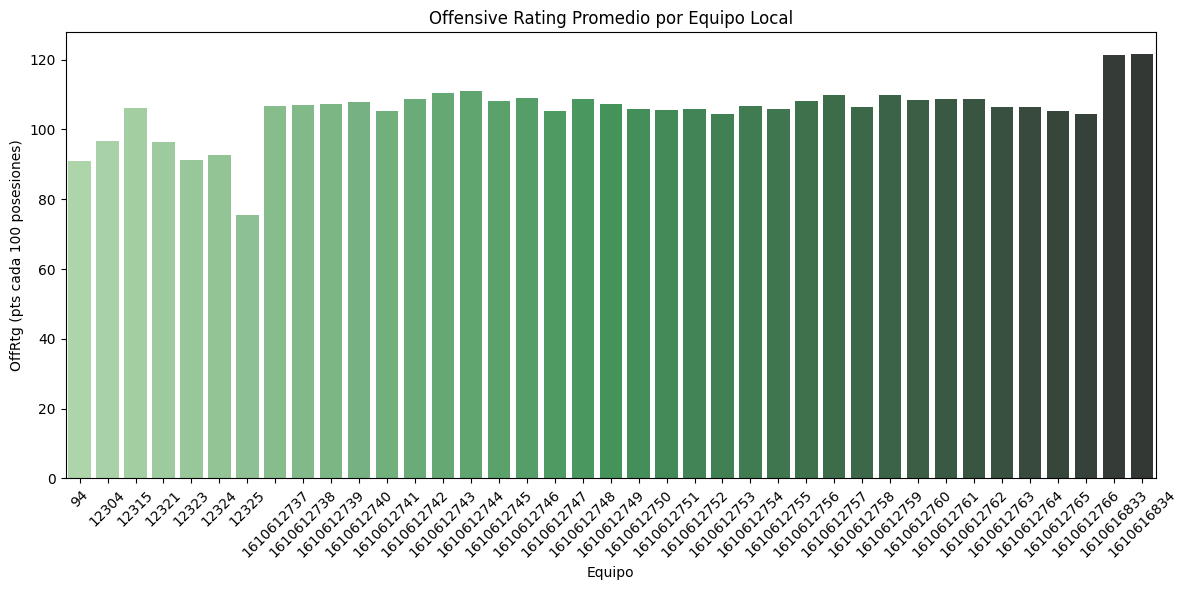

In [35]:
#OFENSIVA

# 1. Calcular OffRtg
df_fact_partidos_2010_2023['offrtg_home'] = (
    df_fact_partidos_2010_2023['pts_home_x'] / df_fact_partidos_2010_2023['poss_home']
) * 100

df_fact_partidos_2010_2023['offrtg_away'] = (
    df_fact_partidos_2010_2023['pts_away_x'] / df_fact_partidos_2010_2023['poss_away']
) * 100

# 2. Visualizar: Promedio OffRtg por equipo local
offrtg_prom = df_fact_partidos_2010_2023.groupby('team_id_home')['offrtg_home'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='team_id_home', y='offrtg_home', data=offrtg_prom, palette='Greens_d')
plt.title('Offensive Rating Promedio por Equipo Local')
plt.ylabel('OffRtg (pts cada 100 posesiones)')
plt.xlabel('Equipo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Los resultados indican que la mayoría de los equipos locales tienen una eficiencia ofensiva muy consistente, promediando alrededor de 105-110 puntos por cada 100 posesiones. Sin embargo, hay una polarización marcada: los equipos 1610616833 y 1610616834 son extremadamente dominantes en ataque en casa, mientras que el equipo 12325 es un claro valor atípico con una eficiencia ofensiva extremadamente baja en comparación con sus competidores.


C:\Users\PC\AppData\Local\Temp\ipykernel_15648\2653281624.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='team_id_home', y='defrtg_home', data=defrtg_prom, palette='Reds_d')


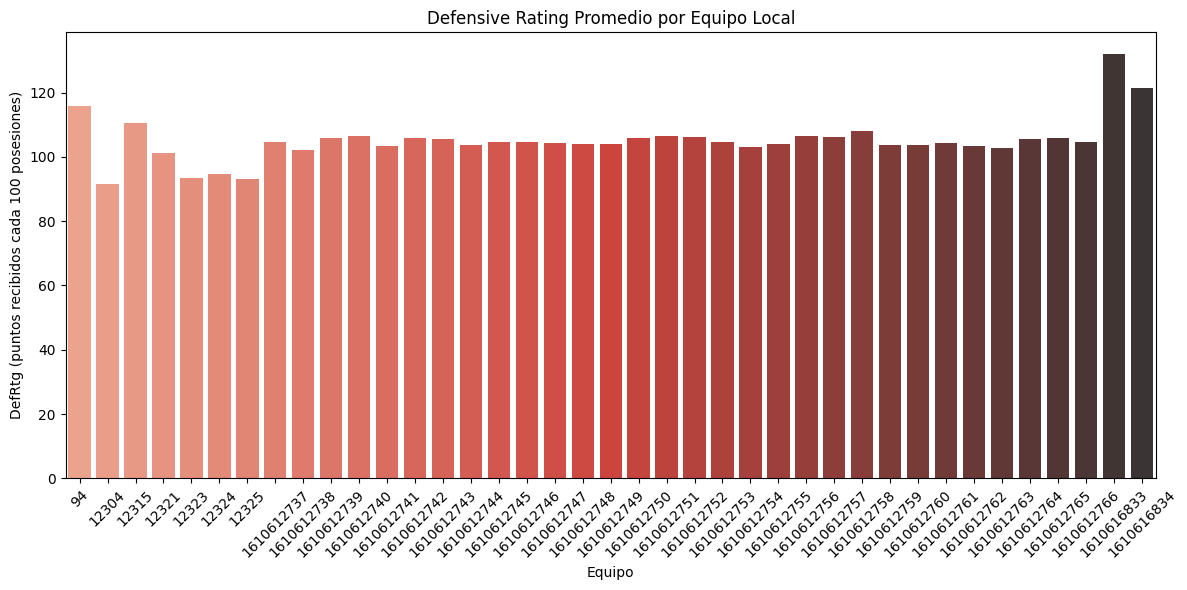

In [36]:
#DEFENSIVA

# 1. Calcular DefRtg
df_fact_partidos_2010_2023['defrtg_home'] = (
    df_fact_partidos_2010_2023['pts_away_x'] / df_fact_partidos_2010_2023['poss_home']
) * 100

df_fact_partidos_2010_2023['defrtg_away'] = (
    df_fact_partidos_2010_2023['pts_home_x'] / df_fact_partidos_2010_2023['poss_away']
) * 100

# 2. Visualizar: Promedio DefRtg por equipo local
defrtg_prom = df_fact_partidos_2010_2023.groupby('team_id_home')['defrtg_home'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='team_id_home', y='defrtg_home', data=defrtg_prom, palette='Reds_d')
plt.title('Defensive Rating Promedio por Equipo Local')
plt.ylabel('DefRtg (puntos recibidos cada 100 posesiones)')
plt.xlabel('Equipo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Los equipos con los identificadores 12304, 12323, y 12324 (barras de color salmón) tienen la mejor defensa, con valores en el rango de 90-95. Estos equipos son los más eficientes defendiendo cuando juegan en casa.


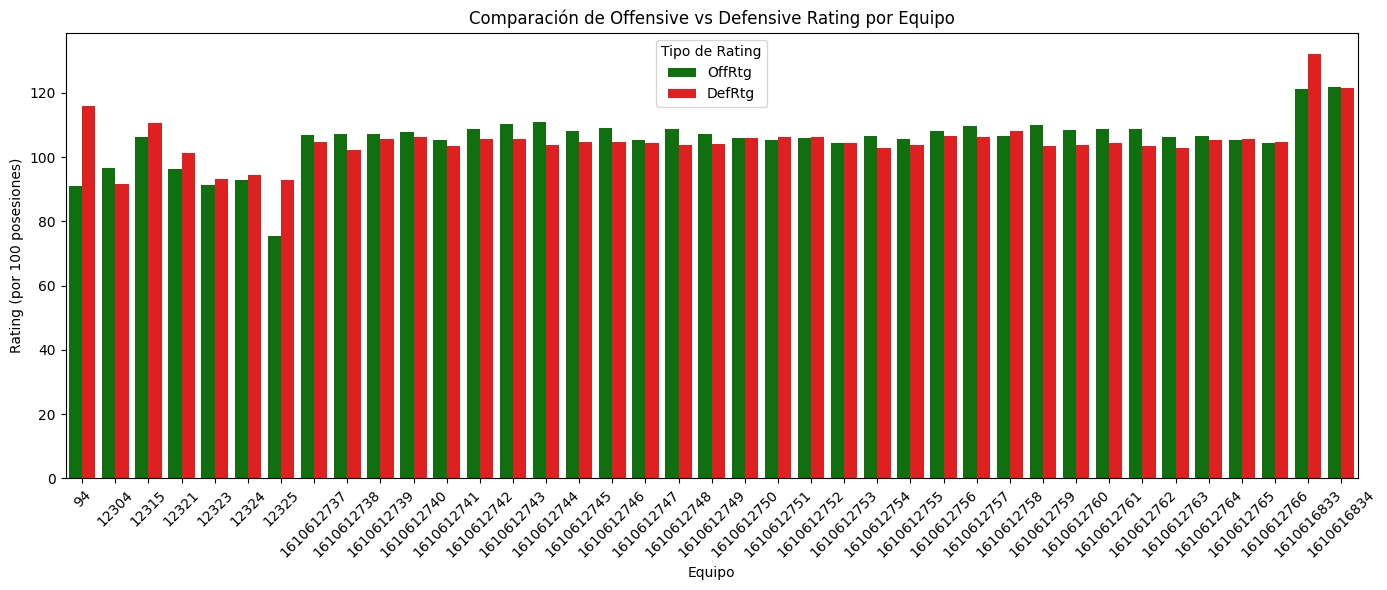

In [37]:
#COMPARACIÓN DEFENSIVA VS OFENSIVA

# Agrupar por equipo local y calcular promedios de OffRtg y DefRtg
ratings_avg = df_fact_partidos_2010_2023.groupby('team_id_home')[['offrtg_home', 'defrtg_home']].mean().reset_index()

# Renombrar columnas para visualización
ratings_avg = ratings_avg.rename(columns={
    'team_id_home': 'team_id',
    'offrtg_home': 'OffRtg',
    'defrtg_home': 'DefRtg'
})

# Reorganizar datos en formato largo para facilitar visualización con seaborn
ratings_melted = pd.melt(ratings_avg, id_vars='team_id', value_vars=['OffRtg', 'DefRtg'],
                         var_name='Tipo', value_name='Rating')

# Visualización comparativa
plt.figure(figsize=(14, 6))
sns.barplot(x='team_id', y='Rating', hue='Tipo', data=ratings_melted, palette=['green', 'red'])

plt.title('Comparación de Offensive vs Defensive Rating por Equipo')
plt.xlabel('Equipo')
plt.ylabel('Rating (por 100 posesiones)')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Rating')
plt.tight_layout()
plt.show()


La mayoría de los equipos locales son netamente eficientes, ya que su capacidad ofensiva supera marginalmente a su vulnerabilidad defensiva. No obstante, existe un grupo inicial de equipos que son ineficientes al permitir consistentemente más puntos de los que anotan (DefRtg > OffRtg). Un caso extremo es el de los equipos 1610616833 y 1610616834, que son los mejores en ataque y los peores en defensa, aunque su superioridad ofensiva les permite mantener una eficiencia neta positiva.


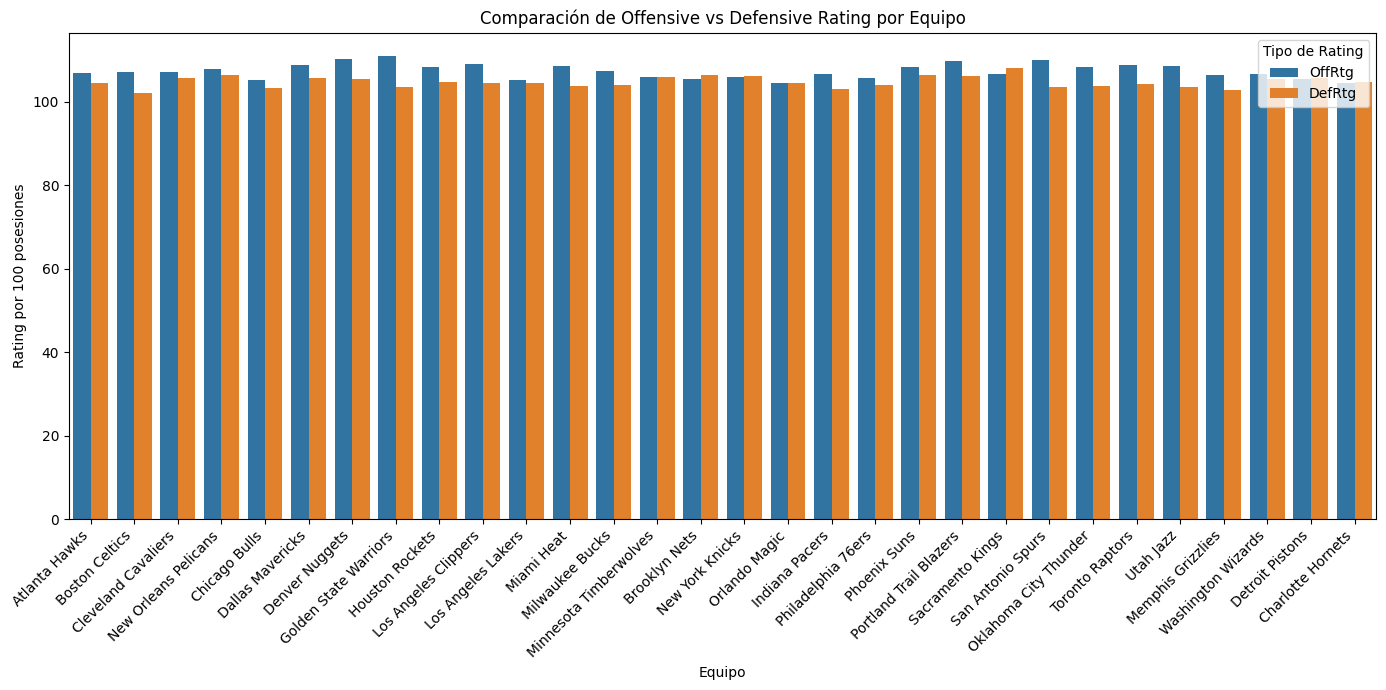

In [38]:


# 1. Calcular estadísticas
def calcular_estadisticas(df):
    df = df.copy()
    df['poss_home'] = df['fga_home'] + 0.44 * df['fta_home'] - df['oreb_home'] + df['tov_home']
    df['poss_away'] = df['fga_away'] + 0.44 * df['fta_away'] - df['oreb_away'] + df['tov_away']
    df['offrtg_home'] = (df['pts_home_x'] / df['poss_home']) * 100
    df['offrtg_away'] = (df['pts_away_x'] / df['poss_away']) * 100
    df['defrtg_home'] = (df['pts_away_x'] / df['poss_home']) * 100
    df['defrtg_away'] = (df['pts_home_x'] / df['poss_away']) * 100
    return df

# 2. Aplicar función
df_fact_partidos_2010_2023 = calcular_estadisticas(df_fact_partidos_2010_2023)

# 3. Agrupar por equipo local y calcular promedios
df_ratings = df_fact_partidos_2010_2023.groupby('team_id_home')[['offrtg_home', 'defrtg_home']].mean().reset_index()
df_ratings.columns = ['team_id', 'OffRtg', 'DefRtg']

# 4. Unir con nombres de equipos
df_ratings = df_ratings.merge(df_dim_team[['team_id', 'team_name']], on='team_id', how='left')

# 5. Transformar para visualización
df_melted = pd.melt(df_ratings, id_vars='team_name', value_vars=['OffRtg', 'DefRtg'],
                    var_name='Tipo', value_name='Rating')

# 6. Visualizar con seaborn
plt.figure(figsize=(14, 7))
sns.barplot(data=df_melted, x='team_name', y='Rating', hue='Tipo', palette=['#1f77b4', '#ff7f0e'])
plt.title('Comparación de Offensive vs Defensive Rating por Equipo')
plt.xlabel('Equipo')
plt.ylabel('Rating por 100 posesiones')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Rating')
plt.tight_layout()
plt.show()


La mayoría de los equipos de la liga tienen una eficiencia neta positiva (OffRtg > DefRtg), lo que significa que en promedio anotan más puntos de los que permiten. Sin embargo, hay un grupo de élite (e.g., Boston, Denver, Golden State) que sobresale por una gran diferencia entre su ataque y defensa, siendo los más eficientes. Un segundo grupo (e.g., Cleveland, Dallas, Portland) presenta una eficiencia neta cercana a cero o ligeramente negativa, lo que sugiere que su rendimiento general es neutro o perdedor en términos de puntos por posesión.


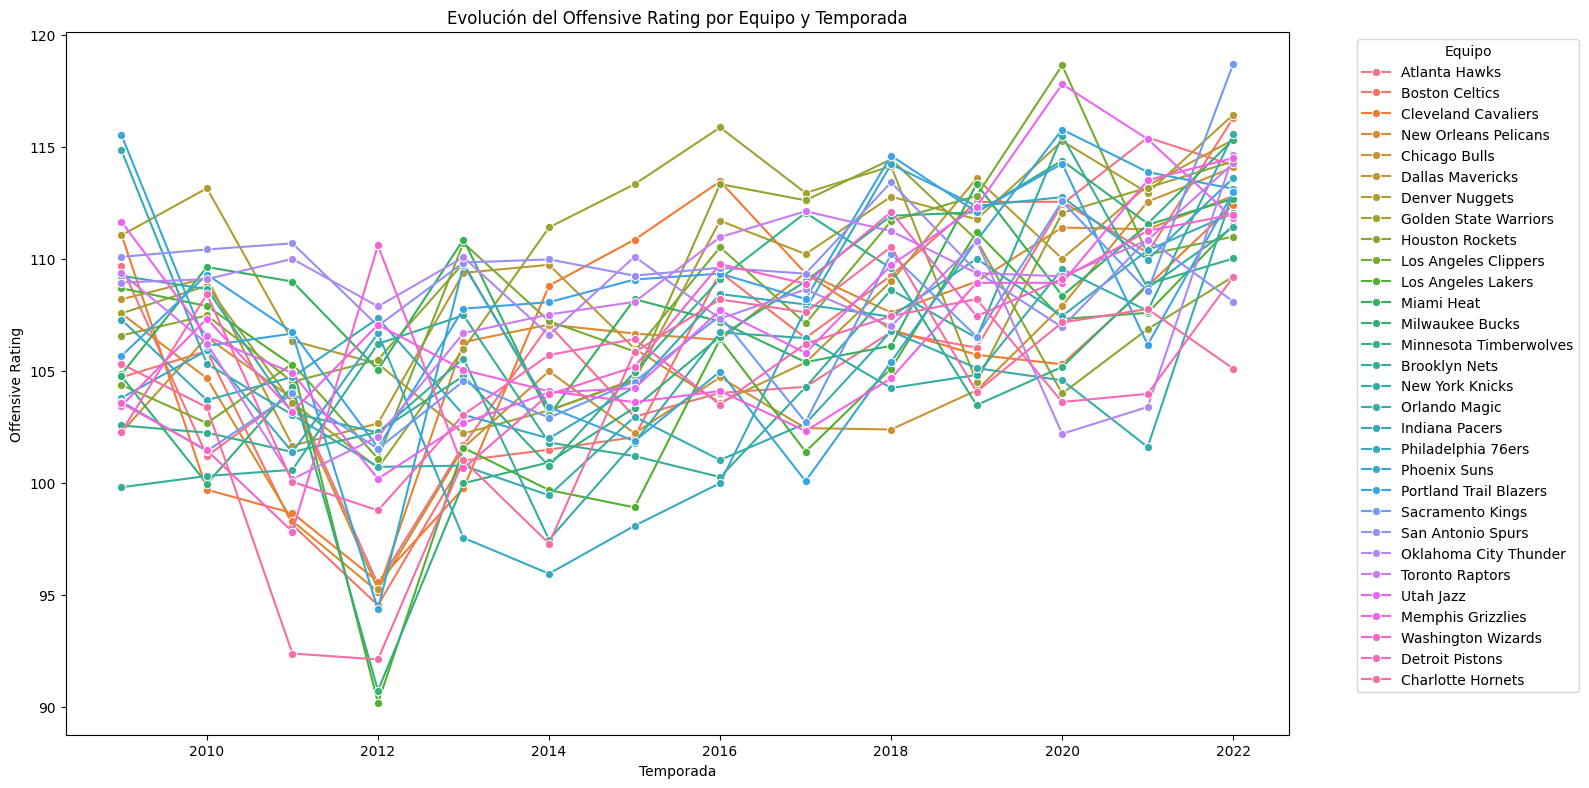

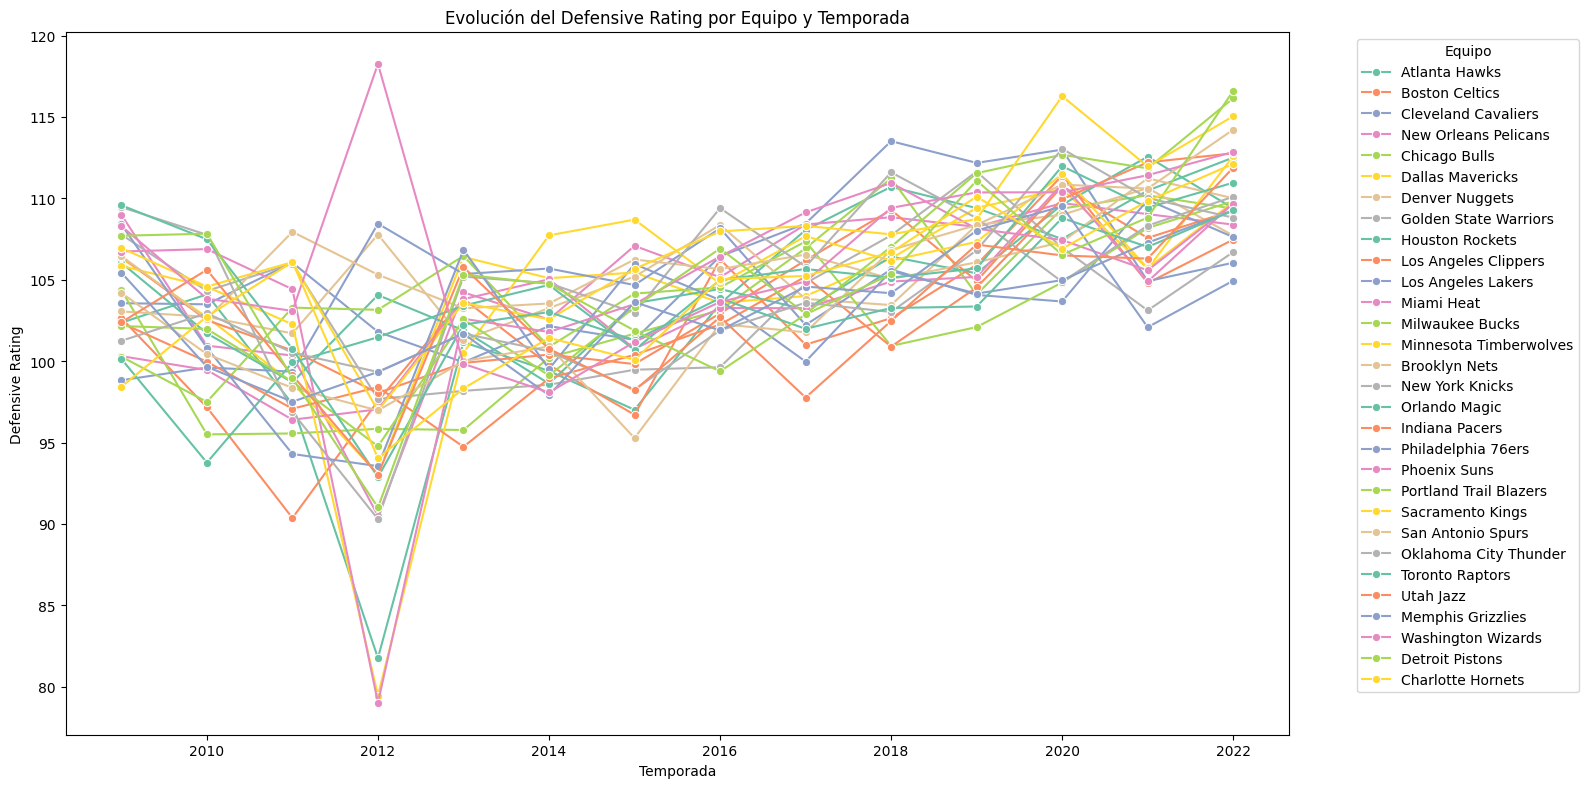

In [39]:
#POR TEMPORADA

# -------------------------------
# 1. Calcular estadísticas avanzadas
# -------------------------------
def calcular_estadisticas(df):
    df = df.copy()
    df['poss_home'] = df['fga_home'] + 0.44 * df['fta_home'] - df['oreb_home'] + df['tov_home']
    df['poss_away'] = df['fga_away'] + 0.44 * df['fta_away'] - df['oreb_away'] + df['tov_away']

    df['offrtg_home'] = (df['pts_home_x'] / df['poss_home']) * 100
    df['offrtg_away'] = (df['pts_away_x'] / df['poss_away']) * 100

    df['defrtg_home'] = (df['pts_away_x'] / df['poss_home']) * 100
    df['defrtg_away'] = (df['pts_home_x'] / df['poss_away']) * 100

    return df

# Aplicar función (asegúrate de tener el DataFrame 'df_fact_partidos_2010_2023' cargado)
df_stats = calcular_estadisticas(df_fact_partidos_2010_2023)

# -------------------------------
# 2. Agrupar por temporada y equipo local
# -------------------------------
df_por_temporada = (
    df_stats.groupby(['season', 'team_id_home'])[['offrtg_home', 'defrtg_home']]
    .mean()
    .reset_index()
    .rename(columns={
        'team_id_home': 'team_id',
        'offrtg_home': 'OffRtg',
        'defrtg_home': 'DefRtg'
    })
)

# Agregar nombre del equipo (asegúrate de tener 'df_dim_team' cargado)
df_por_temporada = df_por_temporada.merge(
    df_dim_team[['team_id', 'team_name']],
    on='team_id',
    how='left'
)

# -------------------------------
# 3. Visualización OffRtg por temporada
# -------------------------------
plt.figure(figsize=(16, 8))
sns.lineplot(data=df_por_temporada, x='season', y='OffRtg', hue='team_name', marker='o')
plt.title('Evolución del Offensive Rating por Equipo y Temporada')
plt.xlabel('Temporada')
plt.ylabel('Offensive Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Equipo')
plt.tight_layout()
plt.show()

# -------------------------------
# 4. Visualización DefRtg por temporada
# -------------------------------
plt.figure(figsize=(16, 8))
sns.lineplot(data=df_por_temporada, x='season', y='DefRtg', hue='team_name', marker='o', palette='Set2')
plt.title('Evolución del Defensive Rating por Equipo y Temporada')
plt.xlabel('Temporada')
plt.ylabel('Defensive Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Equipo')
plt.tight_layout()
plt.show()


La evolución muestra que la eficiencia ofensiva de la NBA ha aumentado drásticamente entre 2009 y 2022, con los equipos pasando de un promedio de ~105 a un promedio de ~115 puntos por cada 100 posesiones. Si bien la mayoría de los equipos experimentan variaciones significativas año tras año, la tendencia general es clara: el baloncesto moderno se caracteriza por un rendimiento ofensivo superior al de la década anterior.

La evolución muestra una tendencia general de declive en la eficiencia defensiva de la NBA; con el tiempo, los equipos han permitido consistentemente más puntos por cada 100 posesiones. Este empeoramiento de la defensa (aumento del DefRtg) es la imagen espejo del auge ofensivo visto en el gráfico anterior, y juntos confirman una era de alto rendimiento ofensivo en el baloncesto moderno.


C:\Users\PC\AppData\Local\Temp\ipykernel_15648\694027347.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['NetRtg'] = df_filtrado['OffRtg'] - df_filtrado['DefRtg']


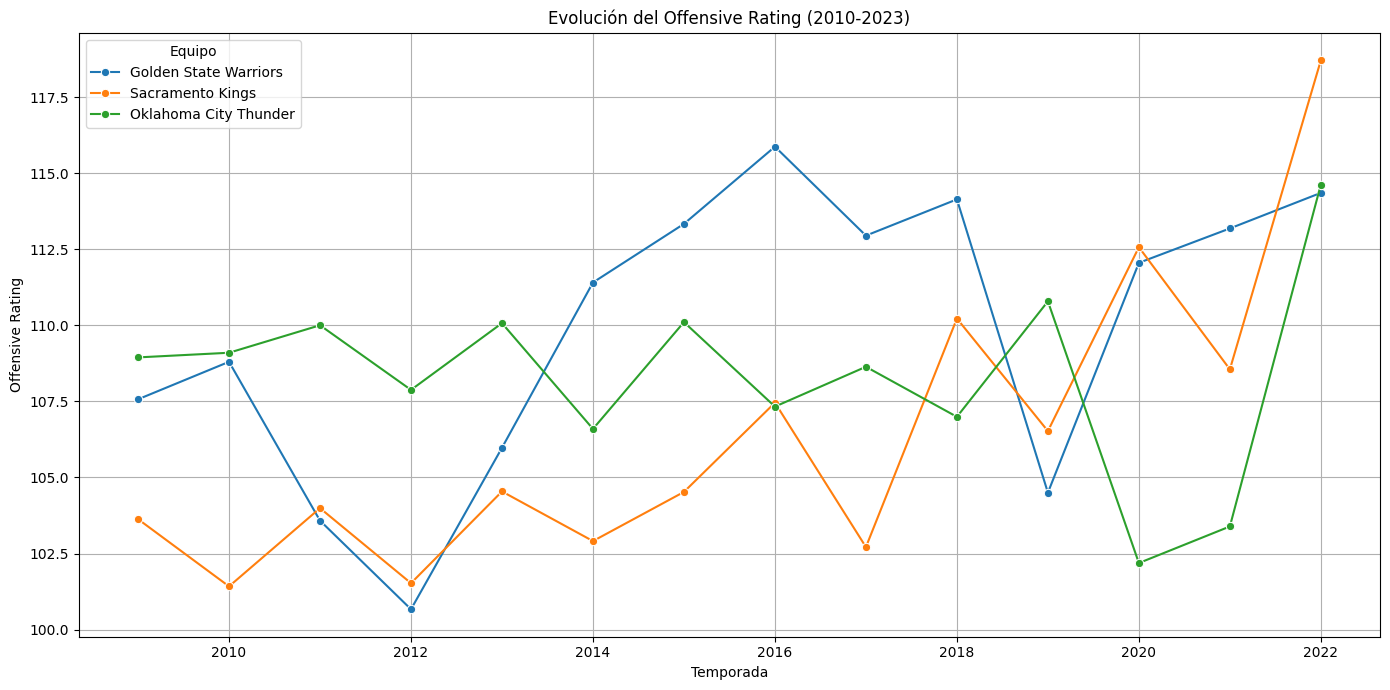

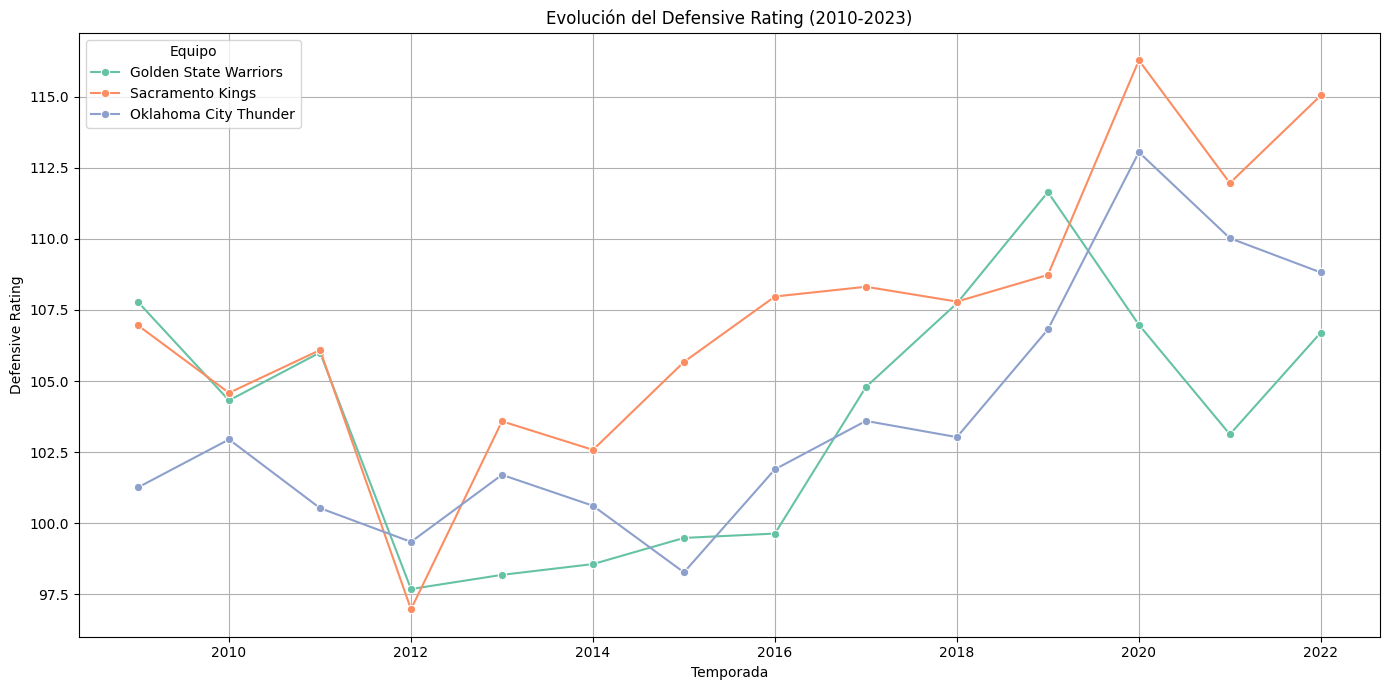

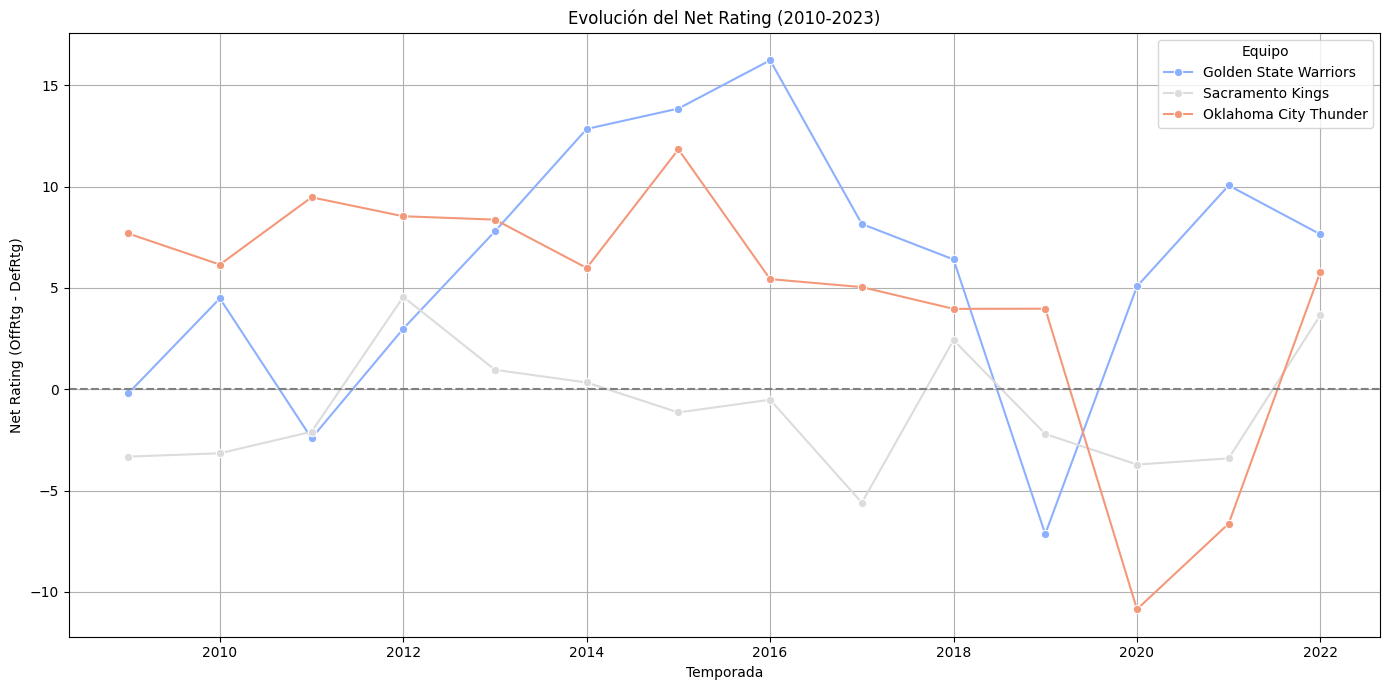

In [40]:
#POR EQUIPOS SELECCIONADOS 'Golden State Warriors', 'Oklahoma City Thunder', 'Sacramento Kings':

# 1. Función para calcular las estadísticas
def calcular_estadisticas(df):
    df = df.copy()
    df['poss_home'] = df['fga_home'] + 0.44 * df['fta_home'] - df['oreb_home'] + df['tov_home']
    df['poss_away'] = df['fga_away'] + 0.44 * df['fta_away'] - df['oreb_away'] + df['tov_away']

    df['offrtg_home'] = (df['pts_home_x'] / df['poss_home']) * 100
    df['offrtg_away'] = (df['pts_away_x'] / df['poss_away']) * 100

    df['defrtg_home'] = (df['pts_away_x'] / df['poss_home']) * 100
    df['defrtg_away'] = (df['pts_home_x'] / df['poss_away']) * 100

    return df

# 2. Calcular estadísticas
df_stats = calcular_estadisticas(df_fact_partidos_2010_2023)

# 3. Agrupar por temporada y equipo local
df_por_temporada = (
    df_stats.groupby(['season', 'team_id_home'])[['offrtg_home', 'defrtg_home']]
    .mean()
    .reset_index()
    .rename(columns={
        'team_id_home': 'team_id',
        'offrtg_home': 'OffRtg',
        'defrtg_home': 'DefRtg'
    })
)

# 4. Agregar nombre del equipo
df_por_temporada = df_por_temporada.merge(
    df_dim_team[['team_id', 'team_name']],
    on='team_id',
    how='left'
)

# 5. Filtrar por equipos específicos
equipos_deseados = ['Golden State Warriors', 'Oklahoma City Thunder', 'Sacramento Kings']
df_filtrado = df_por_temporada[df_por_temporada['team_name'].isin(equipos_deseados)]

# 6. Calcular Net Rating
df_filtrado['NetRtg'] = df_filtrado['OffRtg'] - df_filtrado['DefRtg']

# 7. Visualización - Offensive Rating
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_filtrado, x='season', y='OffRtg', hue='team_name', marker='o')
plt.title('Evolución del Offensive Rating (2010-2023)')
plt.xlabel('Temporada')
plt.ylabel('Offensive Rating')
plt.legend(title='Equipo')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Visualización - Defensive Rating
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_filtrado, x='season', y='DefRtg', hue='team_name', marker='o', palette='Set2')
plt.title('Evolución del Defensive Rating (2010-2023)')
plt.xlabel('Temporada')
plt.ylabel('Defensive Rating')
plt.legend(title='Equipo')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Visualización - Net Rating
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_filtrado, x='season', y='NetRtg', hue='team_name', marker='o', palette='coolwarm')
plt.title('Evolución del Net Rating (2010-2023)')
plt.xlabel('Temporada')
plt.ylabel('Net Rating (OffRtg - DefRtg)')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Equipo')
plt.grid(True)
plt.tight_layout()
plt.show()


Los resultados indican que el Sacramento Kings ha logrado la mayor transformación ofensiva en las últimas temporadas, pasando de ser el menos eficiente a alcanzar el pico de OffRtg más alto de los tres en 2022. Los Golden State Warriors han demostrado la eficiencia más sostenida en la cima durante su periodo de éxito (2015-2016), mientras que el Oklahoma City Thunder ha sido más consistente en las temporadas iniciales y ha mostrado la mayor fluctuación reciente. La tendencia general muestra que la eficiencia ofensiva ha aumentado para los tres equipos en los años más recientes.

La evolución muestra un patrón claro: a pesar de que los tres equipos alcanzaron un pico de excelencia defensiva alrededor de 2012, la tendencia general para los tres ha sido de deterioro defensivo (DefRtg más alto) en la década posterior. Los Golden State Warriors fueron el equipo más eficiente en defensa durante su periodo de dominio, mientras que el Sacramento Kings ha sido el equipo más vulnerable en defensa durante la mayor parte de las últimas temporadas.

La evolución del Net Rating demuestra que los Golden State Warriors fueron el equipo más dominante en eficiencia de los tres durante su pico, mientras que el Sacramento Kings ha sido consistentemente el equipo menos eficiente hasta su reciente mejoría. Los tres equipos muestran una tendencia común de caída severa de la eficiencia en 2020 (el peor año para el Thunder y Warriors), seguida de una fuerte recuperación en 2022, sugiriendo una vuelta a la competitividad en las últimas temporadas.


### EFICIENCIA DE TIRO

In [41]:
#ANALISIS POR EQUIIPOS Y TEMPORADAS

# Calcular estadísticas de tiro por equipo local y visitante
def calcular_eficiencia_tiro(df):
    # Para equipo local
    df_local = df.groupby(['season', 'team_id_home']).agg({
        'fgm_home': 'sum',
        'fga_home': 'sum',
        'fg3m_home': 'sum',
        'fg3a_home': 'sum',
        'ftm_home': 'sum',
        'fta_home': 'sum'
    }).reset_index().rename(columns={'team_id_home': 'team_id'})

    # Para equipo visitante
    df_away = df.groupby(['season', 'team_id_away']).agg({
        'fgm_away': 'sum',
        'fga_away': 'sum',
        'fg3m_away': 'sum',
        'fg3a_away': 'sum',
        'ftm_away': 'sum',
        'fta_away': 'sum'
    }).reset_index().rename(columns={'team_id_away': 'team_id'})

    # Unir local y visitante sumando sus estadísticas
    df_total = pd.merge(df_local, df_away, on=['season', 'team_id'], how='outer').fillna(0)

    # Sumar local + visitante
    df_total['fgm'] = df_total['fgm_home'] + df_total['fgm_away']
    df_total['fga'] = df_total['fga_home'] + df_total['fga_away']
    df_total['fg3m'] = df_total['fg3m_home'] + df_total['fg3m_away']
    df_total['fg3a'] = df_total['fg3a_home'] + df_total['fg3a_away']
    df_total['ftm'] = df_total['ftm_home'] + df_total['ftm_away']
    df_total['fta'] = df_total['fta_home'] + df_total['fta_away']

    # Calcular porcentajes
    df_total['FG%'] = df_total['fgm'] / df_total['fga']
    df_total['3PT%'] = df_total['fg3m'] / df_total['fg3a']
    df_total['FT%'] = df_total['ftm'] / df_total['fta']

    # Limpiar columnas innecesarias
    cols_to_keep = ['season', 'team_id', 'FG%', '3PT%', 'FT%']
    df_total = df_total[cols_to_keep]

    # Agregar nombre de equipo
    df_total = df_total.merge(df_dim_team[['team_id', 'team_name']], on='team_id', how='left')

    # Ordenar por temporada y equipo
    df_total = df_total.sort_values(['season', 'team_name']).reset_index(drop=True)

    return df_total

# Ejecutar
df_eficiencia_tiro = calcular_eficiencia_tiro(df_fact_partidos_2010_2023)

# Mostrar algunas filas
print(df_eficiencia_tiro.head())


   season     team_id       FG%      3PT%       FT%          team_name
0  2009.0  1610612737  0.459322  0.360174  0.766429      Atlanta Hawks
1  2009.0  1610612738  0.470508  0.349780  0.743634     Boston Celtics
2  2009.0  1610612751  0.436930  0.349448  0.783993      Brooklyn Nets
3  2009.0  1610612766  0.459816  0.369136  0.768127  Charlotte Hornets
4  2009.0  1610612741  0.453507  0.330042  0.754808      Chicago Bulls


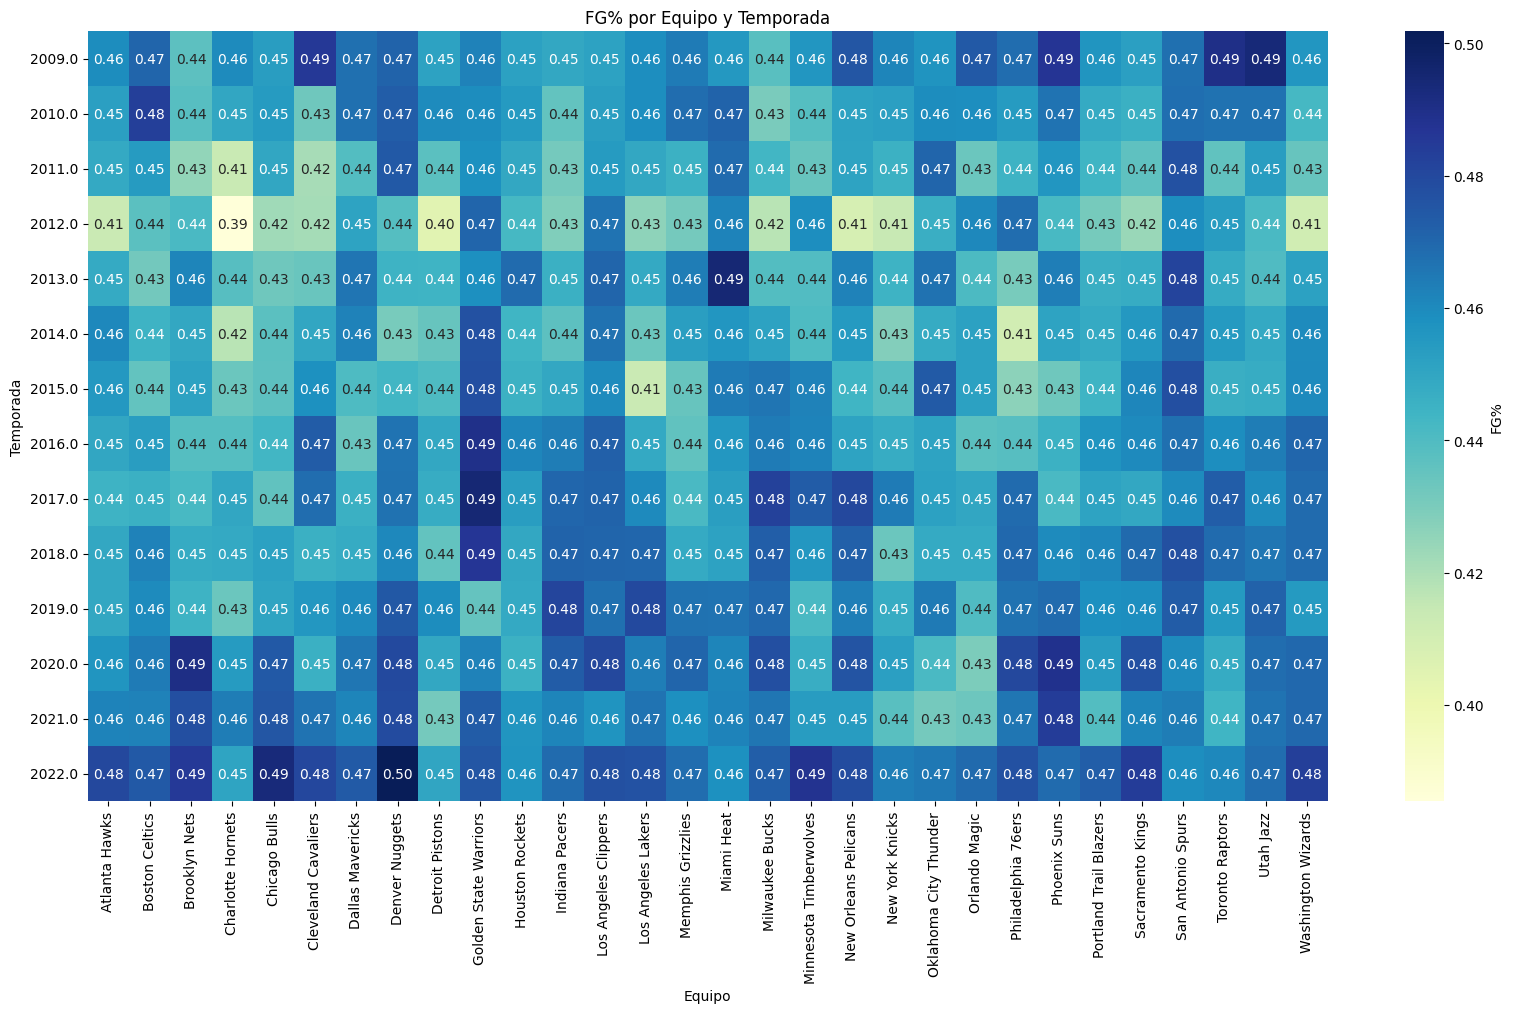

In [44]:
# Agrupar para asegurar que cada equipo en cada temporada tenga un solo valor promedio de FG%
df_agg = df_eficiencia_tiro.groupby(['season', 'team_name'])['FG%'].mean().reset_index()

# Pivot para el heatmap
df_pivot = df_agg.pivot(index='season', columns='team_name', values='FG%')

plt.figure(figsize=(20, 10))
sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'FG%'})

plt.title('FG% por Equipo y Temporada')
plt.xlabel('Equipo')
plt.ylabel('Temporada')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()



La mayoría de los equipos mantienen un Porcentaje de Tiros de Campo (FG%) muy estable entre 0.44 y 0.47. Los equipos como Denver, Lakers y Pistons (recientemente) han demostrado ser los más eficientes en anotar tiros de campo. La relativa estabilidad del FG% a lo largo de los años, a pesar del aumento de la eficiencia ofensiva (OffRtg), sugiere que la revolución ofensiva moderna está impulsada más por la cantidad y el tipo de tiro (ej. triples) que por una mejora masiva en la precisión general de todos los tiros de campo.


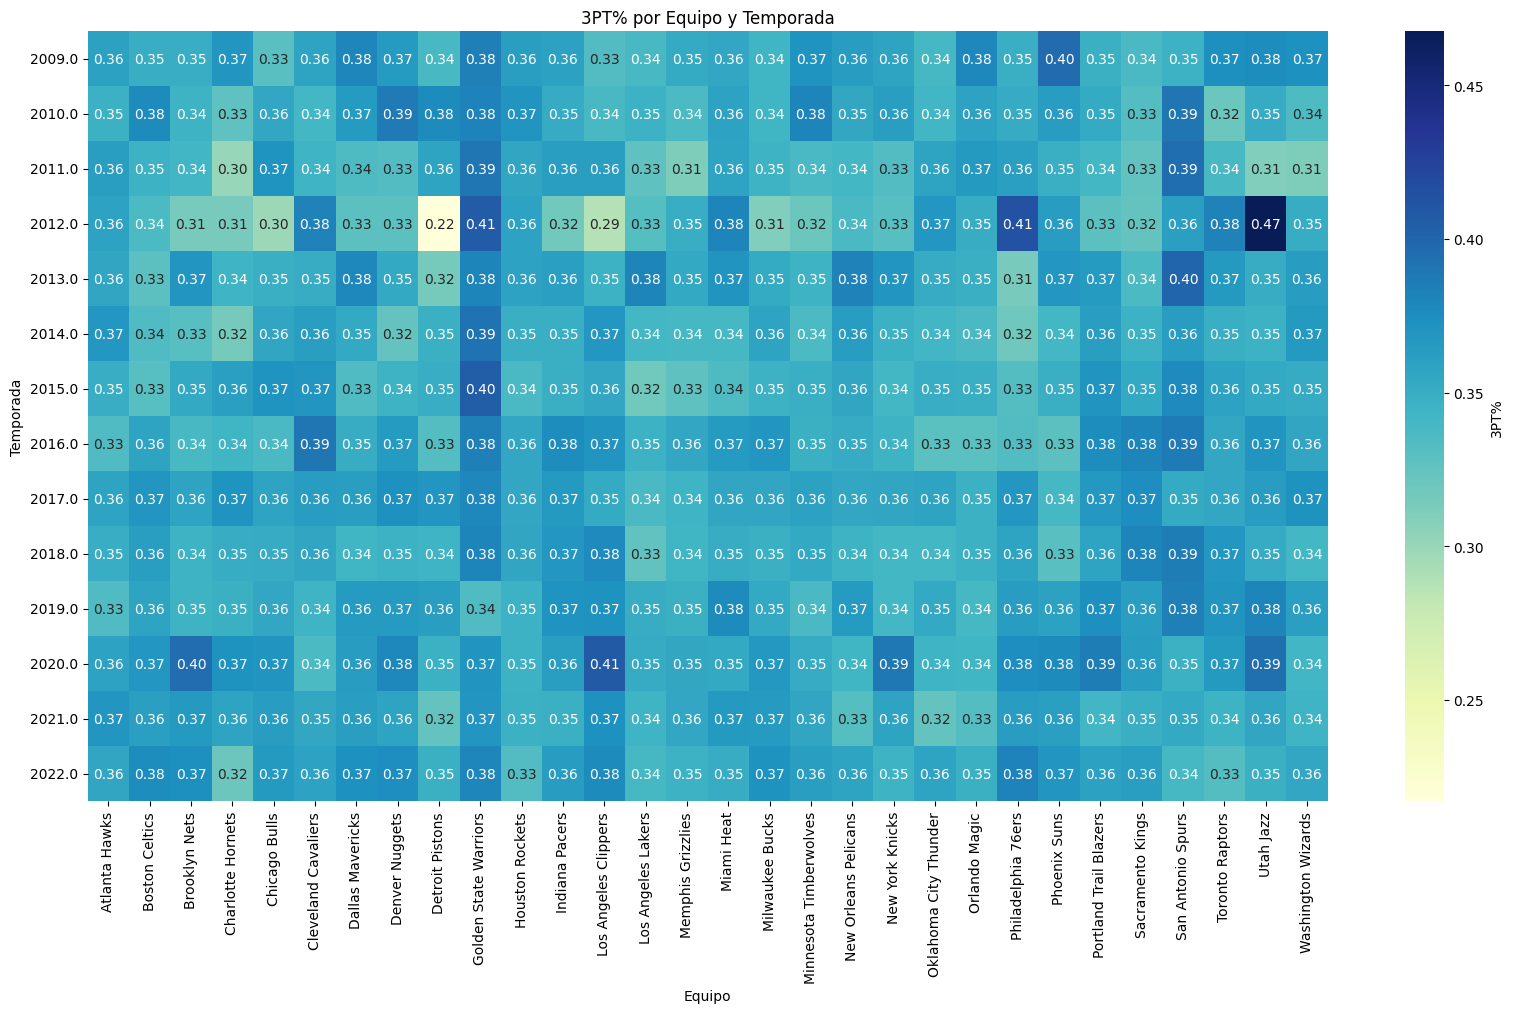

In [46]:
# Agrupar para asegurar que cada equipo en cada temporada tenga un solo valor promedio de FG%
df_agg = df_eficiencia_tiro.groupby(['season', 'team_name'])['3PT%'].mean().reset_index()

# Pivot para el heatmap
df_pivot = df_agg.pivot(index='season', columns='team_name', values='3PT%')

plt.figure(figsize=(20, 10))
sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': '3PT%'})

plt.title('3PT% por Equipo y Temporada')
plt.xlabel('Equipo')
plt.ylabel('Temporada')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

El porcentaje de triples se mantiene altamente concentrado entre 0.34 y 0.38 para la mayoría de los equipos a lo largo de las temporadas. Si bien hay casos atípicos de alta eficiencia (como Utah Jazz en 2012 o Golden State Warriors en su apogeo), la precisión desde la línea de tres no ha mejorado significativamente para la liga en general, sugiriendo que el aumento de la eficiencia ofensiva (OffRtg) se debe más al incremento en la cantidad de triples lanzados que a una mejora masiva en el acierto del tiro de tres.


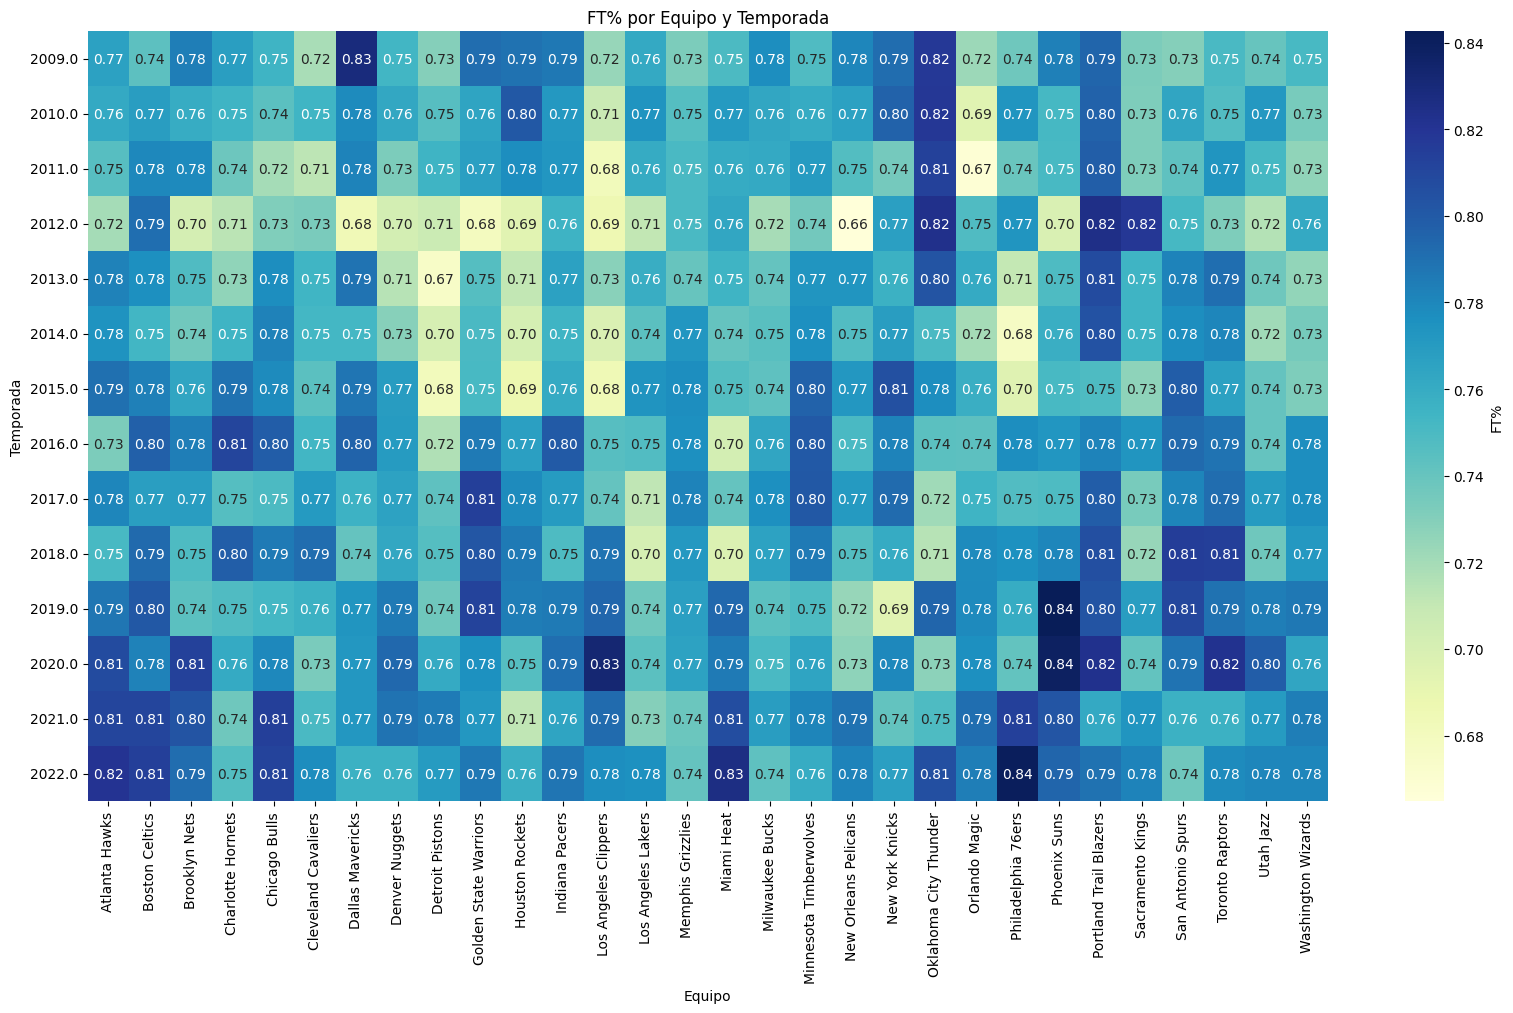

In [47]:
# Agrupar para asegurar que cada equipo en cada temporada tenga un solo valor promedio de FT%
df_agg = df_eficiencia_tiro.groupby(['season', 'team_name'])['FT%'].mean().reset_index()

# Pivot para el heatmap
df_pivot = df_agg.pivot(index='season', columns='team_name', values='FT%')

plt.figure(figsize=(20, 10))
sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'FT%'})

plt.title('FT% por Equipo y Temporada')
plt.xlabel('Equipo')
plt.ylabel('Temporada')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

El porcentaje de Tiros Libres (FT%) de la liga se ha mantenido extremadamente estable y consistente a lo largo de los catorce años analizados, con la mayoría de los equipos flotando alrededor del 0.77. Equipos como Boston Celtics y Golden State Warriors han demostrado ser consistentemente eficientes desde la línea de castigo, mientras que otros han luchado por superar la barrera del 0.70. La estabilidad del FT% sugiere que esta métrica está menos influenciada por los cambios tácticos o reglamentarios del juego moderno en comparación con los tiros de campo o triples.


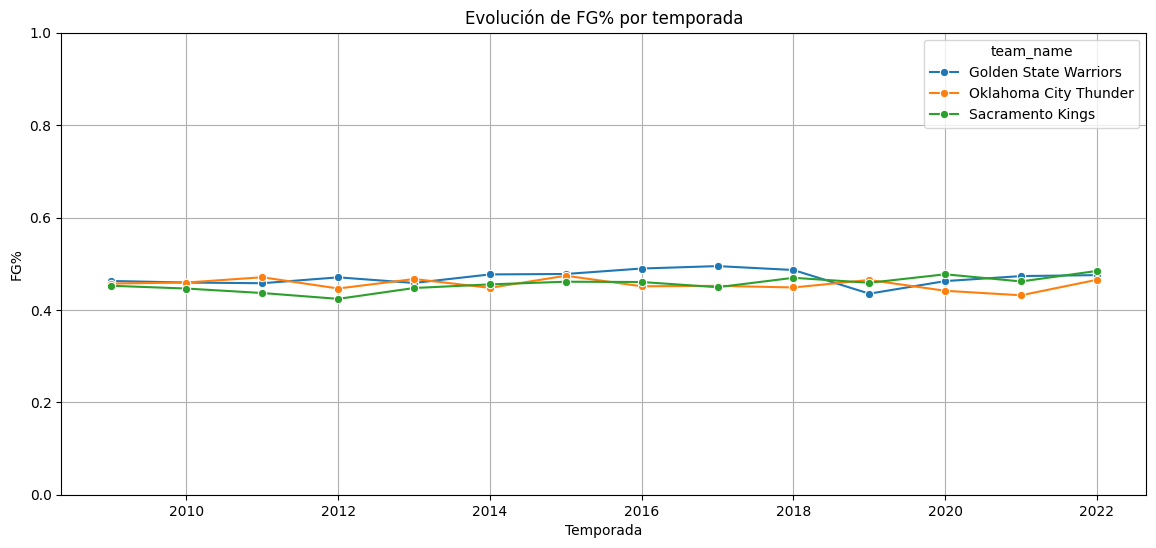

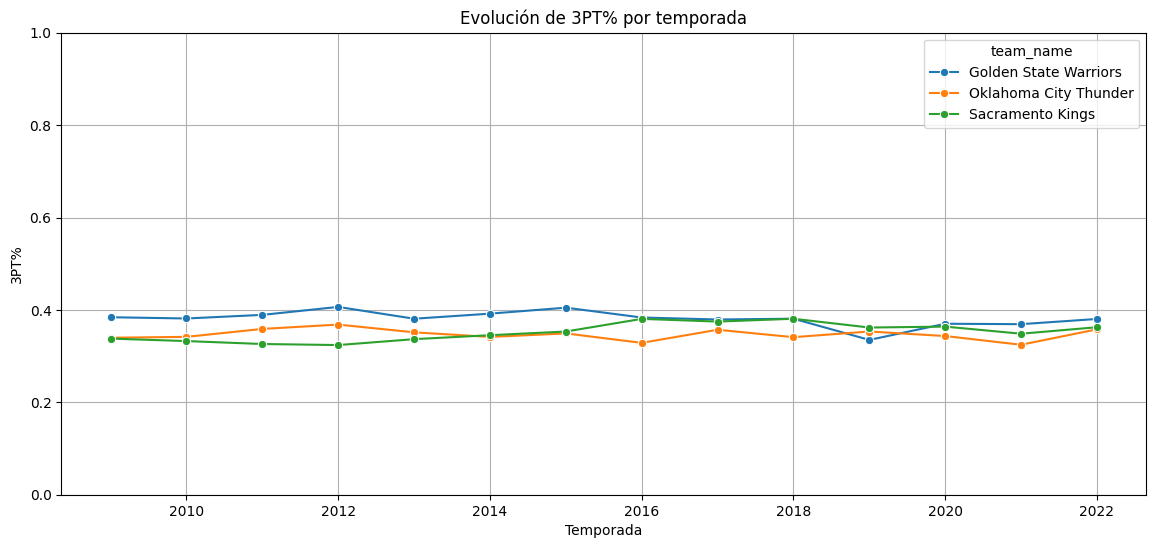

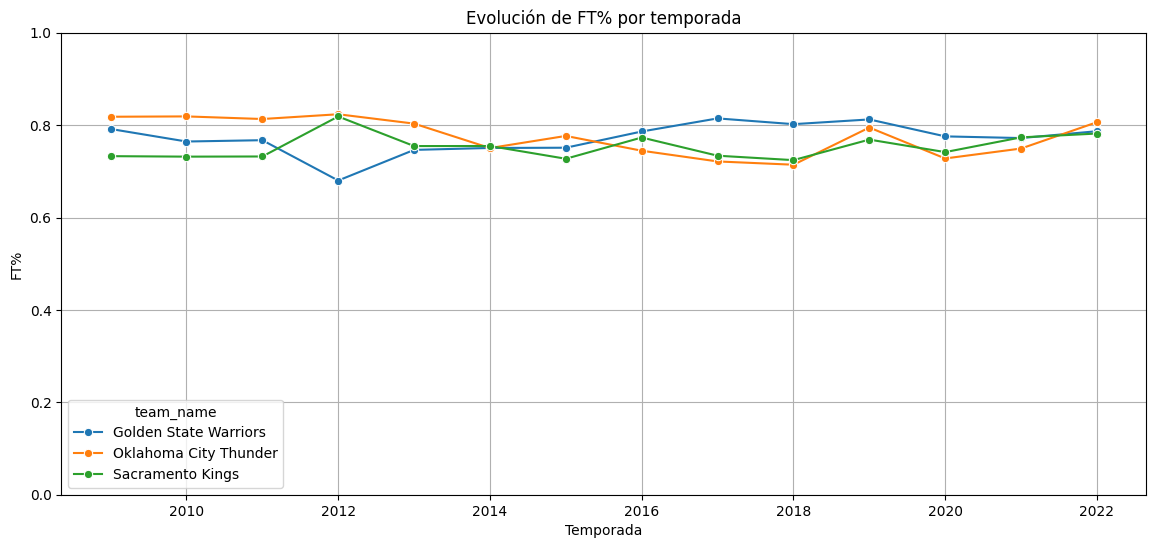

In [48]:
#PARA EQUIPOS SELECCIONADOS

# Equipos que quieres analizar
equipos_deseados = ['Golden State Warriors', 'Oklahoma City Thunder', 'Sacramento Kings']

df_filtrado = df_eficiencia_tiro[df_eficiencia_tiro['team_name'].isin(equipos_deseados)]

# Visualización de FG%
plt.figure(figsize=(14,6))
sns.lineplot(data=df_filtrado, x='season', y='FG%', hue='team_name', marker='o')
plt.title('Evolución de FG% por temporada')
plt.ylabel('FG%')
plt.xlabel('Temporada')
plt.ylim(0,1)
plt.grid(True)
plt.show()

# Visualización de 3PT%
plt.figure(figsize=(14,6))
sns.lineplot(data=df_filtrado, x='season', y='3PT%', hue='team_name', marker='o')
plt.title('Evolución de 3PT% por temporada')
plt.ylabel('3PT%')
plt.xlabel('Temporada')
plt.ylim(0,1)
plt.grid(True)
plt.show()

# Visualización de FT%
plt.figure(figsize=(14,6))
sns.lineplot(data=df_filtrado, x='season', y='FT%', hue='team_name', marker='o')
plt.title('Evolución de FT% por temporada')
plt.ylabel('FT%')
plt.xlabel('Temporada')
plt.ylim(0,1)
plt.grid(True)
plt.show()


La precisión en los tiros de campo (FG%) de los tres equipos se ha mantenido notablemente estable a lo largo de las temporadas, lo que sugiere que las variaciones observadas en la eficiencia neta y ofensiva (vistas en gráficos anteriores) no se deben a un cambio significativo en la habilidad para acertar el tiro en general. Los Golden State Warriors han sido, en promedio, el equipo con mayor FG%, mientras que el Thunder y el Kings han permanecido muy similares, aunque el Kings ha mostrado una ligera ventaja en las temporadas más recientes.

La precisión en el tiro de tres puntos para estos tres equipos ha sido muy estable, manteniéndose cerca del 35-40% durante más de una década. Los Golden State Warriors han sido, en promedio, el líder en 3PT%, reflejando su estilo de juego. La tendencia más notable es la mejora del Sacramento Kings en los últimos años, que ha logrado igualar la eficiencia en triples de sus competidores, lo que es un factor clave detrás de su reciente aumento en el Offensive Rating (visto en gráficos anteriores).

El Porcentaje de Tiros Libres es la métrica más estable para los tres equipos, con todos operando en un rango alto (generalmente entre 75% y 82%). Los Oklahoma City Thunder han sido históricamente el equipo más preciso desde la línea de castigo, pero el Sacramento Kings ha mostrado la mejora más significativa, eliminando su déficit inicial y convergiendo con la alta eficiencia del Thunder y los Warriors en los años recientes.


### Consistencia

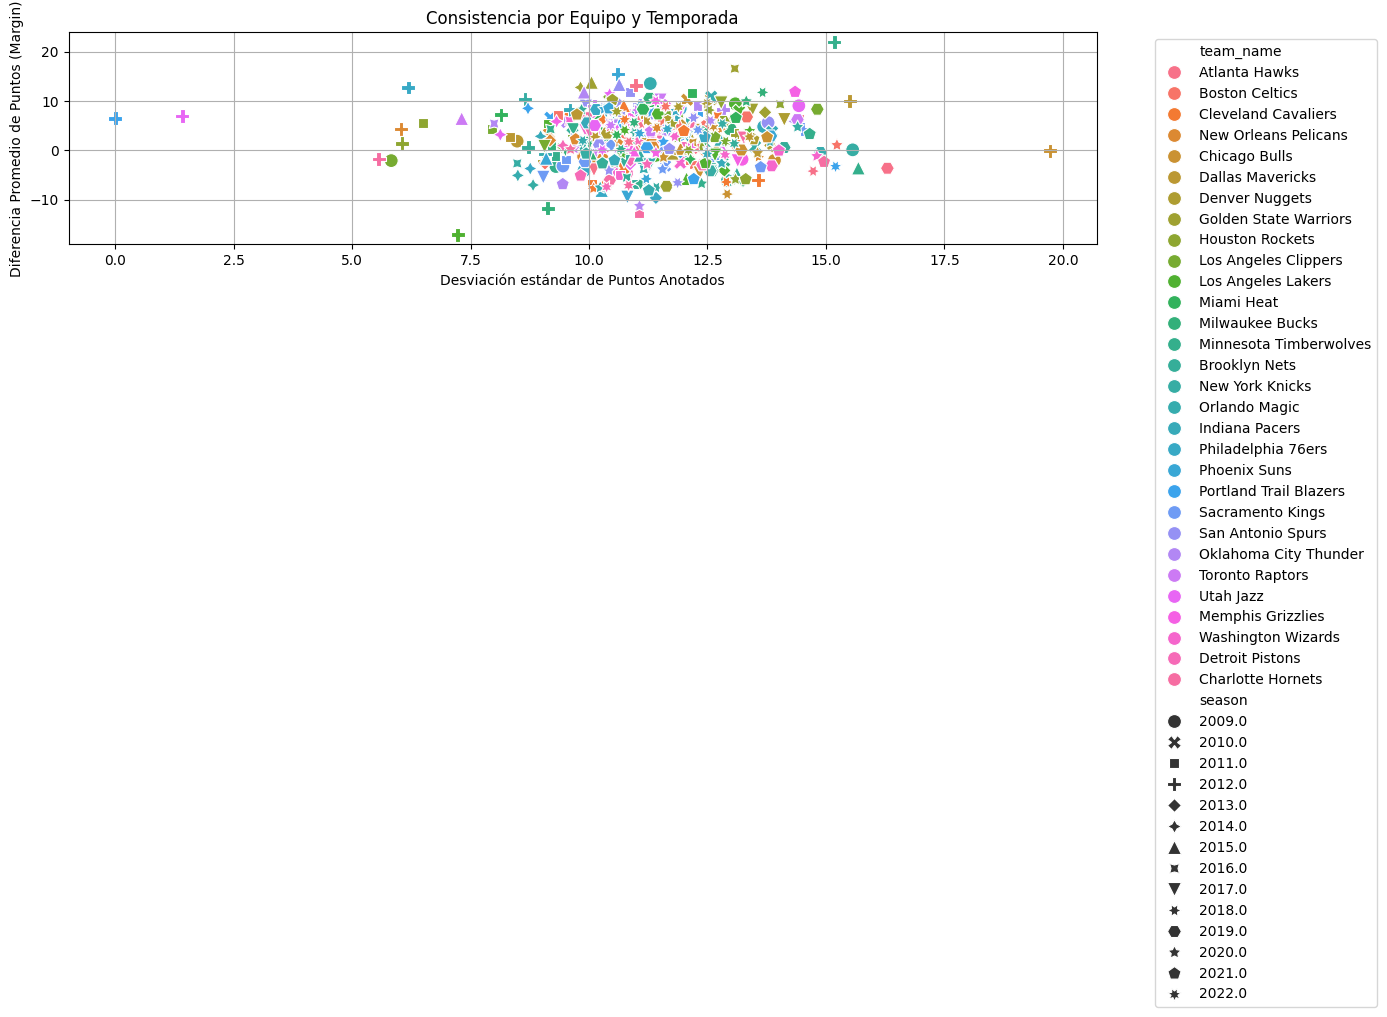

,season,team_name,std_pts_anotados,avg_margin
0,2009.0,Atlanta Hawks,11.141720,6.655172
1,2009.0,Boston Celtics,10.211796,2.054054
2,2009.0,Cleveland Cavaliers,9.618972,7.137931
3,2009.0,New Orleans Pelicans,9.885944,-1.250000
4,2009.0,Chicago Bulls,13.913553,-2.041667
...,...,...,...,...
443,2022.0,Memphis Grizzlies,11.408842,10.000000
444,2022.0,Washington Wizards,12.871623,-0.891892
445,2022.0,Detroit Pistons,10.371334,-7.432432
446,2022.0,Charlotte Hornets,10.835720,-7.125000


In [51]:

# 1. Cálculo de margin (diferencia de puntos anotados - recibidos)
df_fact_partidos_2010_2023['margin'] = df_fact_partidos_2010_2023['pts_home_x'] - df_fact_partidos_2010_2023['pts_away_x']

# 2. Desviación estándar de puntos anotados por equipo local por temporada
df_std = df_fact_partidos_2010_2023.groupby(['season', 'team_id_home'])['pts_home_x'].std().reset_index()
df_std.rename(columns={'pts_home_x': 'std_pts_anotados'}, inplace=True)

# 3. Promedio del margin
df_avg_margin = df_fact_partidos_2010_2023.groupby(['season', 'team_id_home'])['margin'].mean().reset_index()
df_avg_margin.rename(columns={'margin': 'avg_margin'}, inplace=True)

# 4. Unión de ambos resultados
df_consistencia = pd.merge(df_std, df_avg_margin, on=['season', 'team_id_home'])

# 5. Agregar nombre del equipo (a partir de dim_team)
df_consistencia = df_consistencia.merge(df_dim_team[['team_id', 'team_name']],
                                        left_on='team_id_home', right_on='team_id', how='left')
df_consistencia.drop(columns='team_id', inplace=True)

# 6. Visualización: Consistencia vs Margin
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df_consistencia,
    x='std_pts_anotados',
    y='avg_margin',
    hue='team_name',
    style='season',
    s=100
)
plt.title('Consistencia por Equipo y Temporada')
plt.xlabel('Desviación estándar de Puntos Anotados')
plt.ylabel('Diferencia Promedio de Puntos (Margin)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Mostrar tabla resultante
df_consistencia[['season', 'team_name', 'std_pts_anotados', 'avg_margin']]



El gráfico demuestra que el rendimiento exitoso (margen de puntos positivo) no depende de una extrema consistencia ofensiva (baja desviación estándar), ya que los equipos más dominantes se encuentran dentro del rango de variabilidad ofensiva promedio de la liga. La clave del éxito en la NBA se concentra en maximizar el margen promedio de puntos (eje Y), lo que se logra manteniendo un alto rendimiento neto a lo largo de la temporada, independientemente de la volatilidad en la anotación día a día.


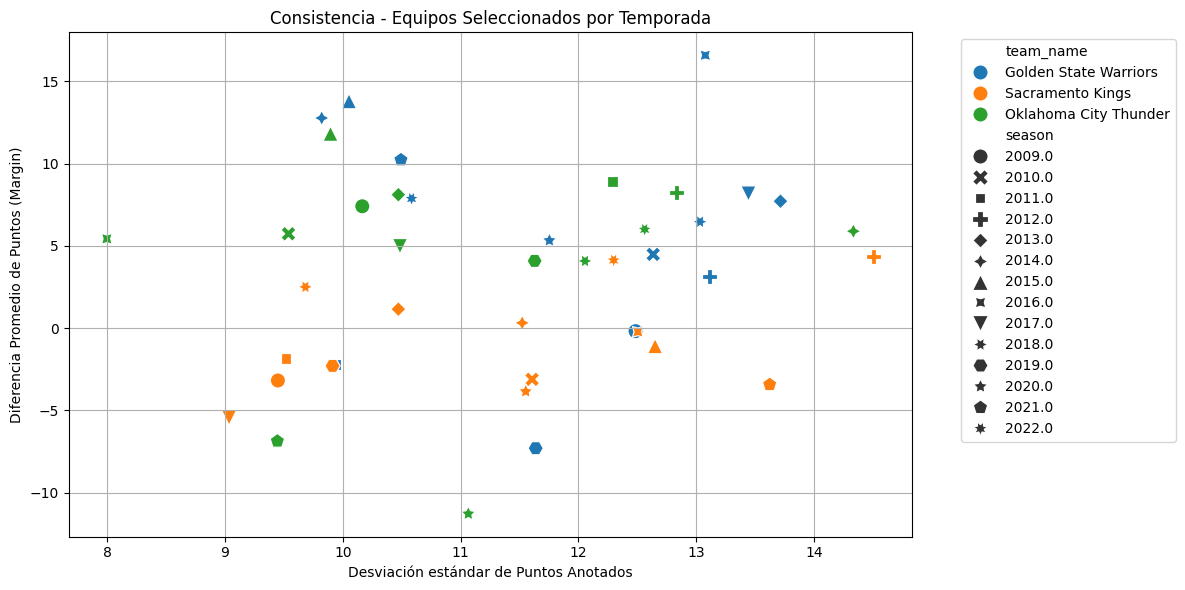

,season,team_name,std_pts_anotados,avg_margin
7,2009.0,Golden State Warriors,12.484637,-0.192308
21,2009.0,Sacramento Kings,9.449364,-3.190476
23,2009.0,Oklahoma City Thunder,10.165300,7.400000
40,2010.0,Golden State Warriors,12.634710,4.476190
54,2010.0,Sacramento Kings,11.606423,-3.119048
56,2010.0,Oklahoma City Thunder,9.539020,5.729167
71,2011.0,Golden State Warriors,9.939100,-2.241379
85,2011.0,Sacramento Kings,9.518604,-1.875000
87,2011.0,Oklahoma City Thunder,12.290736,8.926829
106,2012.0,Golden State Warriors,13.114877,3.142857


In [52]:
#CONSISTENCIA POR EQUIPOS SELECCIONADOS

# Filtrar por equipos específicos
equipos_seleccionados = ['Golden State Warriors', 'Oklahoma City Thunder', 'Sacramento Kings']
df_consistencia_filtrada = df_consistencia[df_consistencia['team_name'].isin(equipos_seleccionados)]

# Visualización filtrada
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_consistencia_filtrada,
    x='std_pts_anotados',
    y='avg_margin',
    hue='team_name',
    style='season',
    s=120
)
plt.title('Consistencia - Equipos Seleccionados por Temporada')
plt.xlabel('Desviación estándar de Puntos Anotados')
plt.ylabel('Diferencia Promedio de Puntos (Margin)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Mostrar tabla filtrada
df_consistencia_filtrada[['season', 'team_name', 'std_pts_anotados', 'avg_margin']]


Para los tres equipos, el éxito (margen de puntos positivo alto) se asocia con un nivel de inconsistencia ofensiva promedio o alto (desviación estándar alta), no con la máxima consistencia. Los equipos dominantes (Warriors y Thunder en sus mejores años) se destacaron por tener los márgenes de puntos más altos. El Sacramento Kings fue consistentemente el menos eficiente y con menor margen de puntos durante el periodo analizado, y su reciente mejoría de rendimiento parece ir de la mano con una mayor volatilidad ofensiva.


### TENDENCIA HISTORICA

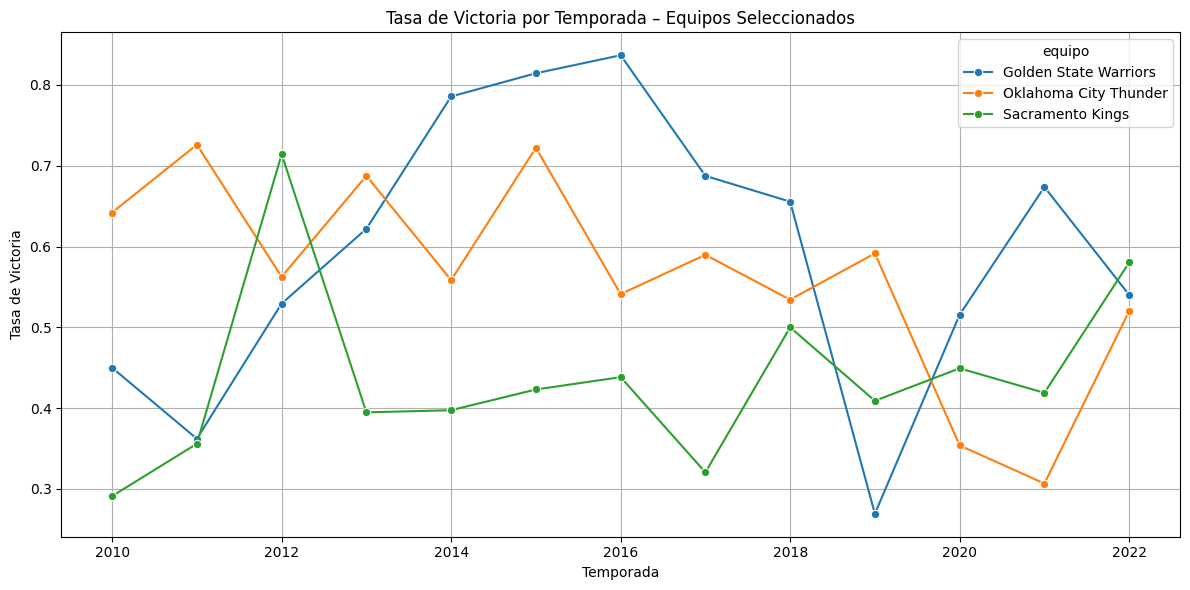

In [53]:
#por euqipos seleccionados

# Equipos y temporadas a filtrar
equipos_filtrados = [
    'Golden State Warriors',
    'Oklahoma City Thunder',
    'Sacramento Kings'
]
temporadas_filtradas = list(range(2010, 2024))

# Asegurarse de que las fechas estén en formato datetime
df_fact_partidos_2010_2023['game_date_x'] = pd.to_datetime(df_fact_partidos_2010_2023['game_date_x'])

# Agregar nombre de equipos locales y visitantes
df = df_fact_partidos_2010_2023.merge(df_dim_team[['team_id', 'team_name']], left_on='team_id_home', right_on='team_id', how='left')
df.rename(columns={'team_name': 'team_name_home'}, inplace=True)
df.drop(columns=['team_id'], inplace=True)

df = df.merge(df_dim_team[['team_id', 'team_name']], left_on='team_id_away', right_on='team_id', how='left')
df.rename(columns={'team_name': 'team_name_away'}, inplace=True)
df.drop(columns=['team_id'], inplace=True)

# Filtrar por equipos seleccionados y temporadas
df_filtrado = df[
    ((df['team_name_home'].isin(equipos_filtrados)) | (df['team_name_away'].isin(equipos_filtrados))) &
    (df['season'].isin(temporadas_filtradas))
].copy()

# Agregar resultado de victoria para local y visitante
df_filtrado['win_home'] = df_filtrado['wl_home'].map({'W': 1, 'L': 0})
df_filtrado['win_away'] = df_filtrado['wl_away'].map({'W': 1, 'L': 0})

# Asignar el equipo relevante a cada fila
def asignar_equipo(row):
    if row['team_name_home'] in equipos_filtrados:
        return row['team_name_home']
    else:
        return row['team_name_away']

df_filtrado['equipo'] = df_filtrado.apply(asignar_equipo, axis=1)

# Determinar si ese equipo ganó el partido
def resultado_equipo(row):
    if row['team_name_home'] == row['equipo']:
        return row['win_home']
    else:
        return row['win_away']

df_filtrado['victoria'] = df_filtrado.apply(resultado_equipo, axis=1)

# Agrupar por temporada y equipo para obtener tasa de victoria
df_resultado = df_filtrado.groupby(['season', 'equipo'])['victoria'].mean().reset_index()

# Visualizar
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_resultado, x='season', y='victoria', hue='equipo', marker='o')
plt.title('Tasa de Victoria por Temporada – Equipos Seleccionados')
plt.xlabel('Temporada')
plt.ylabel('Tasa de Victoria')
plt.grid(True)
plt.tight_layout()
plt.show()



El gráfico ilustra claramente el periodo de dominio de los Golden State Warriors (2014-2019) con tasas de victoria consistentemente superiores. Por otro lado, muestra la lucha constante de los Sacramento Kings por lograr una temporada con balance positivo (Tasa de Victoria superior a 0.50), lo que solo consiguen esporádicamente. Los Oklahoma City Thunder mostraron ser un equipo de élite en la primera parte de la década, pero su rendimiento decayó drásticamente en los últimos años del periodo analizado.


### VENTAJA DE LOCALÍA

In [54]:

df = df_fact_partidos_2010_2023.copy()

# Calcular victorias en casa
victorias_casa = df[df['wl_home'] == 'W'].groupby('season').size()

# Calcular total de partidos por temporada (solo cuenta uno por partido)
partidos_totales = df.groupby('season').size()

# Calcular % victorias en casa
porcentaje_victorias_casa = (victorias_casa / partidos_totales * 100).round(2)

# Calcular victorias fuera
victorias_fuera = df[df['wl_away'] == 'W'].groupby('season').size()

# Calcular % victorias fuera
porcentaje_victorias_fuera = (victorias_fuera / partidos_totales * 100).round(2)

# Calcular ventaja de localía
ventaja_localia = (porcentaje_victorias_casa - porcentaje_victorias_fuera).round(2)

# Crear DataFrame final
df_ventaja_localia = pd.DataFrame({
    'season': porcentaje_victorias_casa.index,
    '%_victorias_casa': porcentaje_victorias_casa.values,
    '%_victorias_fuera': porcentaje_victorias_fuera.values,
    'ventaja_localia': ventaja_localia.values
}).reset_index(drop=True)

# Visualizar resultados
print(df_ventaja_localia)


    season  %_victorias_casa  %_victorias_fuera  ventaja_localia
0   2009.0             58.44              41.56            16.88
1   2010.0             61.54              38.46            23.08
2   2011.0             59.92              40.08            19.84
3   2012.0             63.78              36.22            27.56
4   2013.0             57.12              42.88            14.24
5   2014.0             57.81              42.19            15.62
6   2015.0             59.39              40.61            18.78
7   2016.0             58.17              41.83            16.34
8   2017.0             58.32              41.68            16.64
9   2018.0             59.72              40.28            19.44
10  2019.0             55.18              44.82            10.36
11  2020.0             54.66              45.34             9.32
12  2021.0             54.94              45.06             9.88
13  2022.0             57.81              42.19            15.62


La tabla demuestra que la ventaja de localía en la liga es un fenómeno deportivo robusto y medible. El factor de jugar en casa típicamente agrega entre 14 y 27 puntos porcentuales a la probabilidad de victoria. La única desviación significativa y temporal de esta norma ocurrió en las temporadas 2020 y 2021, donde la ausencia de público debido a la pandemia redujo la ventaja de localía a su mínimo histórico (menos del 10%), lo que subraya el rol fundamental del ambiente de la cancha (la afición, los viajes, etc.) como motor de este fenómeno. La temporada 2022 indica un regreso a la normalidad de este efecto.


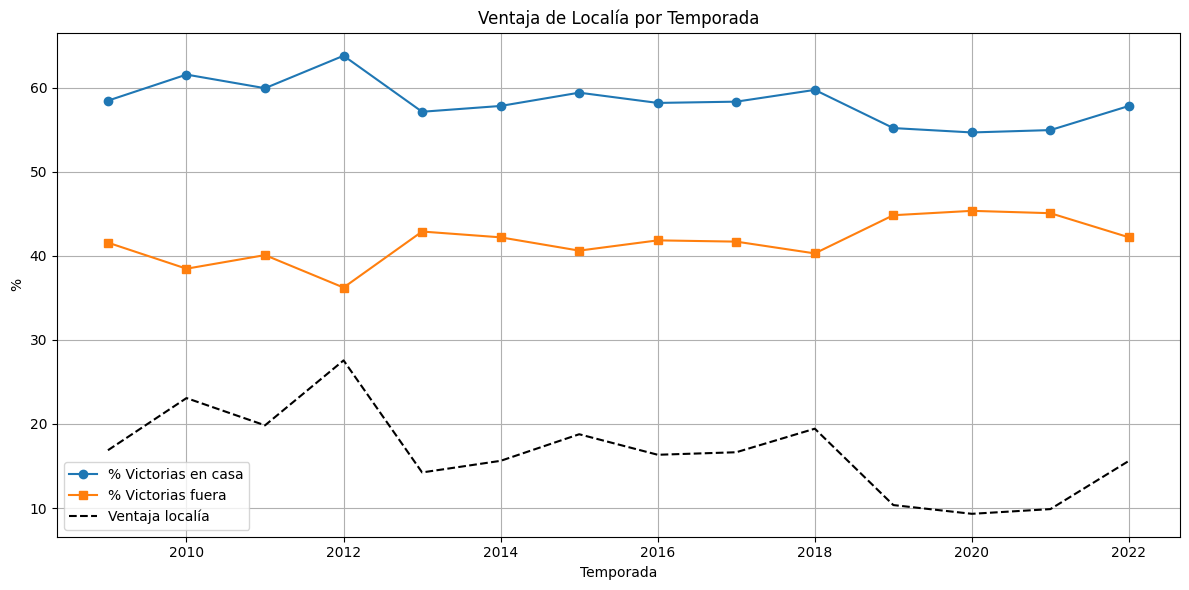

In [55]:

plt.figure(figsize=(12,6))
plt.plot(df_ventaja_localia['season'], df_ventaja_localia['%_victorias_casa'], label='% Victorias en casa', marker='o')
plt.plot(df_ventaja_localia['season'], df_ventaja_localia['%_victorias_fuera'], label='% Victorias fuera', marker='s')
plt.plot(df_ventaja_localia['season'], df_ventaja_localia['ventaja_localia'], label='Ventaja localía', linestyle='--', color='black')
plt.xlabel('Temporada')
plt.ylabel('%')
plt.title('Ventaja de Localía por Temporada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


El gráfico ofrece una poderosa conclusión sobre el fenómeno deportivo de la ventaja de localía:

La ventaja de localía es real y sustancial, fluctuando entre el 15% y el 27% en condiciones normales. Sin embargo, esta ventaja está directamente vinculada a factores ambientales y de la afición, como lo demuestra su colapso histórico durante las temporadas 2020-2021, que se jugaron sin el apoyo de los espectadores. El factor de "casa" es esencialmente la influencia del público y el entorno, no solo la familiaridad con la cancha. La recuperación observada en 2022 confirma el regreso a la normalidad de este fenómeno tras el retorno de los aficionados.


In [57]:
# Merge para obtener nombre equipo local
df = df_fact_partidos_2010_2023.merge(df_dim_team[['team_id', 'team_name']], left_on='team_id_home', right_on='team_id')
df = df.rename(columns={'team_name': 'team_name_home'}).drop('team_id', axis=1)

# Merge para obtener nombre equipo visitante
df = df.merge(df_dim_team[['team_id', 'team_name']], left_on='team_id_away', right_on='team_id')
df = df.rename(columns={'team_name': 'team_name_away'}).drop('team_id', axis=1)

# Lista de equipos que quieres analizar
equipos = ['Golden State Warriors', 'Oklahoma City Thunder', 'Sacramento Kings']

# Lista para guardar los resultados
resultados = []

# Iterar por cada equipo
for equipo in equipos:
    # Partidos como local
    df_home = df[df['team_name_home'] == equipo]
    victorias_casa = df_home[df_home['wl_home'] == 'W'].shape[0]
    total_casa = df_home.shape[0]
    pct_casa = (victorias_casa / total_casa) * 100 if total_casa > 0 else 0

    # Partidos como visitante
    df_away = df[df['team_name_away'] == equipo]
    victorias_fuera = df_away[df_away['wl_away'] == 'W'].shape[0]
    total_fuera = df_away.shape[0]
    pct_fuera = (victorias_fuera / total_fuera) * 100 if total_fuera > 0 else 0

    # Ventaja localía
    ventaja = pct_casa - pct_fuera

    # Guardar resultados
    resultados.append({
        'equipo': equipo,
        '%_victorias_casa': round(pct_casa, 2),
        '%_victorias_fuera': round(pct_fuera, 2),
        'ventaja_localia': round(ventaja, 2)
    })

# Crear DataFrame final con los resultados
df_ventaja_equipos = pd.DataFrame(resultados)

# Mostrar resultados
print(df_ventaja_equipos)


                  equipo  %_victorias_casa  %_victorias_fuera  ventaja_localia
0  Golden State Warriors             71.24              51.40            19.84
1  Oklahoma City Thunder             63.93              47.84            16.09
2       Sacramento Kings             44.38              35.06             9.32


La tabla resume las diferentes realidades competitivas de los tres equipos durante el periodo analizado:

1. Golden State Warriors: Claramente el equipo dominante y de élite. Ganó la mayoría de sus partidos en todas partes, pero con un rendimiento en casa que los hizo casi imbatibles.

2. Oklahoma City Thunder: Un equipo fuerte y ganador que se benefició significativamente de jugar en casa, manteniéndose cerca del nivel de élite.

3. Sacramento Kings: Un equipo perdedor en el periodo, ya que no logró ganar la mayoría de sus partidos ni siquiera en su cancha local. Su escasa ventaja de localía subraya su bajo nivel general de competitividad en la liga.

En resumen, la tabla destaca que el factor cancha beneficia a todos los equipos, pero su verdadero impacto se amplifica en los equipos de élite (Warriors), mientras que un bajo rendimiento general (Kings) puede mitigar el efecto de la ventaja de localía.


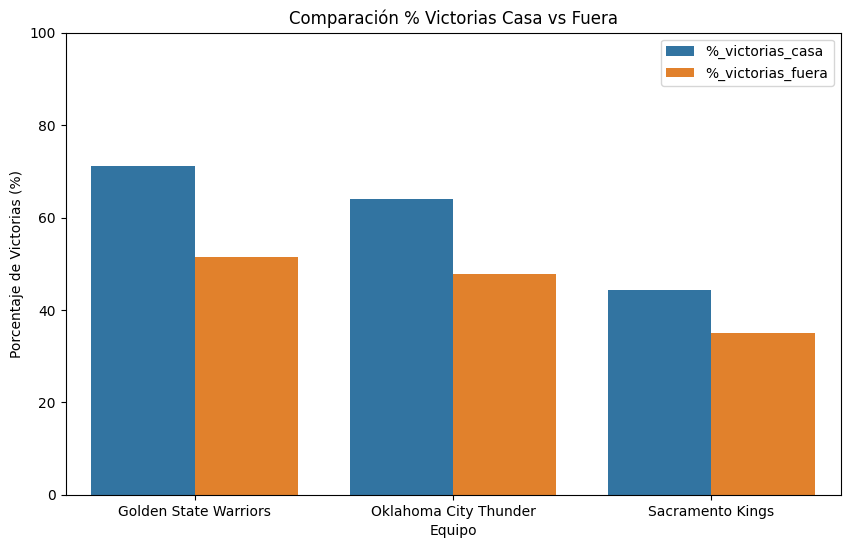

In [58]:
# 'equipo', '%_victorias_casa', '%_victorias_fuera', 'ventaja_localia'

df_plot = df_ventaja_equipos.melt(id_vars='equipo', value_vars=['%_victorias_casa', '%_victorias_fuera'], 
                                 var_name='Lugar', value_name='Porcentaje')

plt.figure(figsize=(10,6))
sns.barplot(data=df_plot, x='equipo', y='Porcentaje', hue='Lugar')
plt.title('Comparación % Victorias Casa vs Fuera')
plt.ylabel('Porcentaje de Victorias (%)')
plt.xlabel('Equipo')
plt.ylim(0, 100)
plt.legend(title='')
plt.show()


Los dos gráficos en conjunto ofrecen una imagen completa del rendimiento:
1. Dominio de GSW: El gráfico de líneas muestra la época de dominio de los Warriors (pico de 0.80+ en 2016), y el gráfico de barras confirma que este dominio se tradujo en una superioridad en todas las canchas (el único con % de victorias fuera del 50%+).
2. Volatilidad de OKC: El gráfico de líneas muestra que el OKC fue un equipo con altos y bajos extremos (variando entre 0.55 y 0.72), pero el gráfico de barras confirma que, en promedio, fueron un equipo ganador y fuerte gracias a su rendimiento en casa.
3. Lucha Constante de SAC: El gráfico de líneas muestra a los Kings con una Tasa de Victoria consistentemente baja (generalmente por debajo de 0.50 o justo en 0.50), y el gráfico de barras reafirma que fueron un equipo perdedor en el promedio general, incapaces de ganar la mayoría de sus partidos incluso en su propia casa.

Confirmación de la Localía: La diferencia entre las barras azul y naranja para cada equipo en el gráfico de barras representa la Ventaja de Localía para ese equipo, mostrando que el factor cancha siempre fue un impulsor de victorias, incluso para un equipo con un rendimiento pobre como Sacramento.
